# Third Assignment

##MSc course in Artificial Intelligence

Mattia Palmiotto

In [27]:
# !rm -r AI_USI_MA/
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

fatal: destination path 'AI_USI_MA' already exists and is not an empty directory.


name: eil76
nPoints: 76
best_sol: 538.0


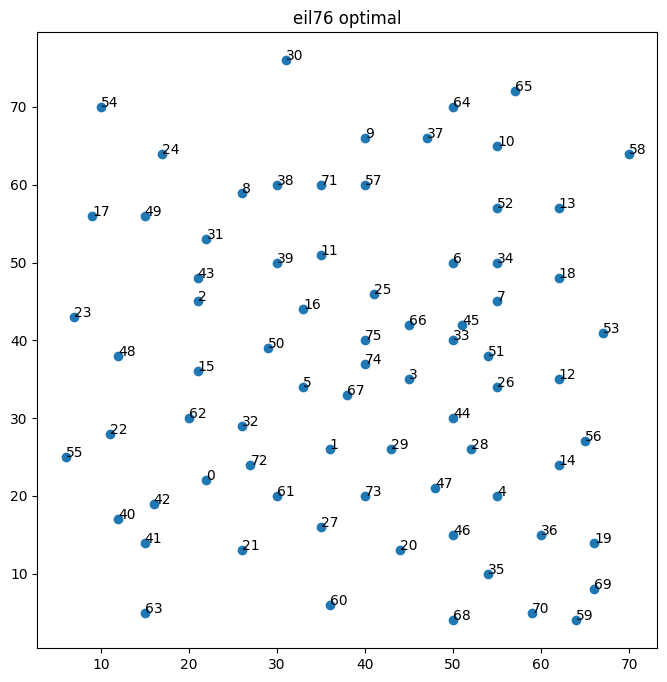

In [28]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

In [29]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


name: d198
nPoints: 198
best_sol: 15780.0


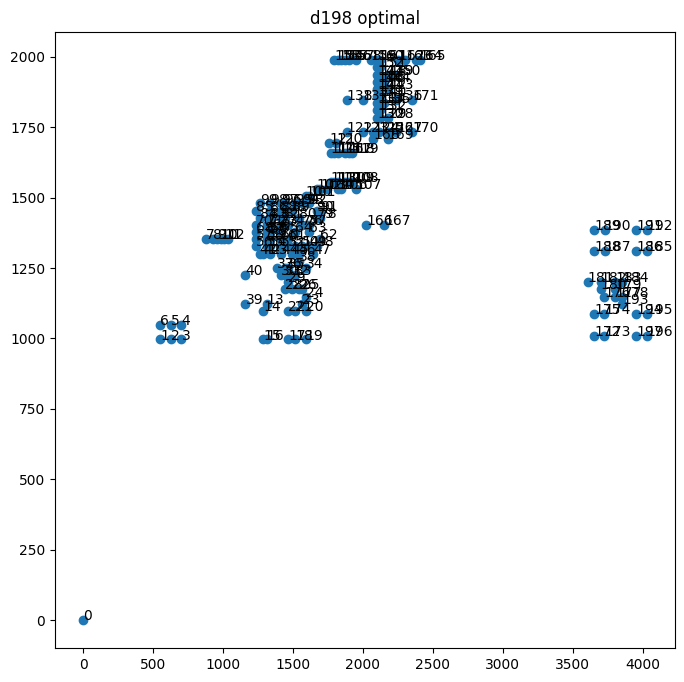

In [30]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


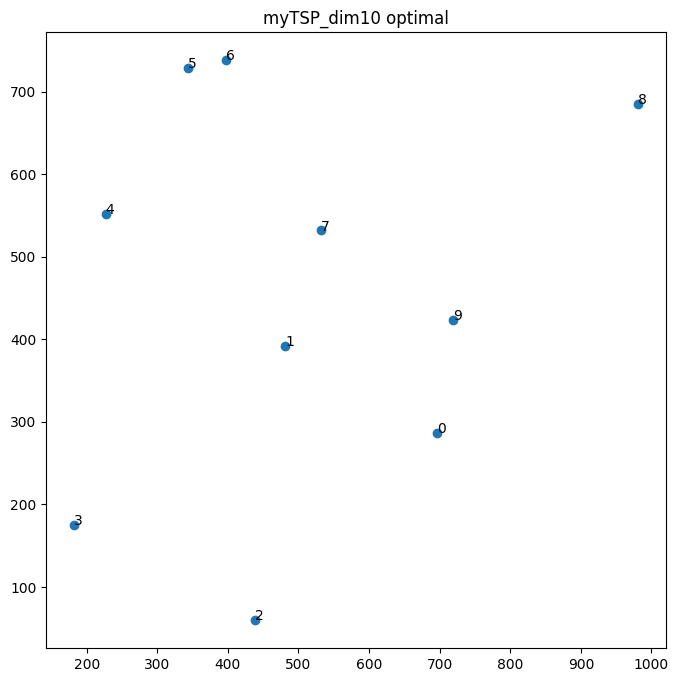

In [31]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [24]:
import numpy as np
from time import time
from AI_USI_MA.solvers.local_search import twoOpt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl
from AI_USI_MA.solvers.constructive_algorithms import nn

# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10                  # number of ants
  beta = 2                # it determines the relative importance of pheromone versus distance
  alpha = rho = 0.1       # parameters of pheromone decay
  cl = 15                 # cardinality of the candidate lists

  @staticmethod
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def __init__(self, instance, two_opt=True, q0=0.98, candidate_bool=False,  runtime=180):
    self.n = instance.nPoints                                                             # number of cities
    self.dist_mat = instance.dist_matrix                                                  # distances between cities
    self.nn, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n)) # solution found by nearest neighbor
    self.tau0 = 1./(float(self.n) * self.L_nn)                                            # tau0
    self.position = {i: None for i in range(ACS.m)}                                       # position collector for the Ants, TO BE UPDATED during the steps
    self.tour = {i: [] for i in range(ACS.m)}                                             # tour collector for the Ants
    self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}                       # I don't use this in the code but another method
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)}                       # it generates the candidate list
    self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)} # I don't use this in the code but another method

    self.candidate_bool = candidate_bool
    self.two_opt = two_opt

    self.tau_edge = np.full((self.n,self.n), self.tau0)   # the matrix of tau for all edges
    np.fill_diagonal(self.tau_edge, 0)

    if q0 == 'adaptive':                                      # it defines q0
      self.q0 = 1 - 13/self.n
    else:
      self.q0 = q0

    self.to_be_visited = None                                  # it keeps track of the cities not yet visited by each ant at the current iteration
    with np.errstate(divide='ignore', invalid='ignore'):
      self.eta_complete = np.where(self.dist_mat > 0, 1 / self.dist_mat, 0)  # it founds eta
    self.numerator_values = None                # this will be needed during the transition rule
    self.tour_lengths = None                    # it stores the values of the lengths of the tours of the current iteration

    self.index_best = None                      # the index of the shortest tour in self.tour
    self.current_best_tour = self.nn            # the best tour of the current iteration
    self.current_min_length = self.L_nn         # the shortest tour of the current iteration
    self.best_tour = self.nn                    # the shortest tour ever found
    self.global_best = self.L_nn                # the lengths of the shortest tour ever found
    self.delta_tau = 1/self.global_best
    self.current_iteration = 0                  # it keeps track of the number of iterations
    self.best_iteration = 0                     # the iteration in which the shortest tour has been found
    self.tours_to_best = 0                      # the number of tours generated before finding the shortest one

    self.global_updating_matrix = np.zeros(shape=(self.n,self.n))
    for c in range(self.n-1):
      r, s = self.nn[c], self.nn[c+1]
      self.global_updating_matrix[r,s], self.global_updating_matrix[s,r] = 1, 1
    r, s = self.nn[self.n-1], self.nn[0]
    self.global_updating_matrix[r,s], self.global_updating_matrix[s,r] = 1, 1

    self.mean_length = np.array([])             # it stores the mean length of the tours of each iteration
    self.sd_length = np.array([])               # it stores the standard devition of the length of the tours of each iteration

    self.start_time = None                      # it stores the time just before strting the first iteration
    self.runtime = runtime                      # the running time of the method self.solve()



  def solve(self):                              # it checks the which solving strategy must be used

    if self.two_opt == True:
      if self.candidate_bool == True:
        self.solve_opt_cl()
      else:
        self.solve_opt()
    else:
      self.solve_without_opt()


  def solve_without_opt(self):                       # naive ACS

    self.start_time = time()                         # it initialises the starting time

    while time()-self.start_time < self.runtime :    # it checks the running condition

      self.current_iteration += 1

      ### 1) INITIALIZATION

      self.initialize_acs()                          # it prepares for building the tours

      ### 2) TOURS BUILDING

      for c in range(self.n):

          if c < self.n-1:
            for ant in range(ACS.m):
              J_k = self.to_be_visited[ant]          # J_k is the list of possible cities to be visited ba the ant
              self.move_to_next_city(ant,J_k)        # it performs a transition to another city
          else:
            for ant in range(ACS.m):
              self.back_to_start(ant)                # the ant goes back to the origin of its tour

      ### 3) GLOBAL UPDATING

      self.compute_tour_lengths()                    # it evaluates the lengths of tour of the current iteration

      self.mean_length = np.append(self.mean_length,np.mean(self.tour_lengths))
      self.sd_length = np.append(self.sd_length,np.std(self.tour_lengths))

      self.global_updating()


  def solve_opt(self):                                    # ACS with 2opt and no candidate list

    self.start_time = time()                              # it initialises the starting time

    while time()-self.start_time < self.runtime:          # it checks the running condition

      self.current_iteration += 1

      ### 1) INITIALIZATION

      self.initialize_acs()                               # it prepares for building the tours

      ### 2) TOURS BUILDING

      for c in range(self.n):

          if c < self.n-1:
            for ant in range(ACS.m):
              J_k = self.to_be_visited[ant]               # J_k is the list of possible cities to be visited ba the ant
              self.move_to_next_city(ant,J_k)             # it performs a transition to another city
          else:
            for ant in range(ACS.m):
              self.back_to_start(ant)

      ### 3) GLOBAL UPDATING

      self.compute_tour_lengths()                        # it evaluates the lengths of tour of the current iteration
      self.two_opt_search()                              # it performs 2opt search on the best tour of the current iteration

      self.mean_length = np.append(self.mean_length,np.mean(self.tour_lengths))
      self.sd_length = np.append(self.sd_length,np.std(self.tour_lengths))

      self.global_updating()


  def solve_opt_cl(self):                                # ACS with 2opt and candidate list

    self.start_time = time()                             # it initialises the starting time

    while time()-self.start_time < self.runtime :

      self.current_iteration += 1

      ### 1) INITIALIZATION

      self.initialize_acs()                               # it prepares for building the tours

      ### 2) TOURS BUILDING

      for c in range(self.n):

          if c < self.n-1:
            for ant in range(ACS.m):
              J_k = self.find_J_k(ant)                    # J_k is the list of possible cities to be visited ba the ant
              self.move_to_next_city(ant,J_k)             # it performs a transition to another city
          else:
            for ant in range(ACS.m):
              self.back_to_start(ant)                     # the ant goes back to the origin of its tour

      ### 3) GLOBAL UPDATING

      self.compute_tour_lengths()                         # it evaluates the lengths of tour of the current iteration
      self.two_opt_search_candidate()                     # it performs 2opt search with candidate list on the best tour of the current iteration

      self.mean_length = np.append(self.mean_length,np.mean(self.tour_lengths))
      self.sd_length = np.append(self.sd_length,np.std(self.tour_lengths))
      self.global_updating()


  def initialize_acs(self):

    self.to_be_visited = {i: list(range(self.n)) for i in range(ACS.m)}           # it initialises self.to_be_visited
    self.tour = {i: [] for i in range(ACS.m)}                                     # it initialises self.tour

    starting_cities = np.random.choice(np.arange(self.n),size=ACS.m,replace=False) # the origins of the tours

    for ant in range(ACS.m):                               # it assings each to a city and updates the variables
      city = starting_cities[ant]
      self.position[ant] = city
      self.tour[ant].append(city)
      self.to_be_visited[ant].remove(city)

  def find_J_k(self,ant):                                  # it finds J_k in case of presence of candidate list

    city = self.position[ant]
    candidates, tour = self.candidate_list[city], self.tour[ant]

    J_k = [c for c in candidates if c not in tour]
    if len(J_k) == 0:
      J_k = self.to_be_visited[ant]

    return J_k

  def exploitation(self,ant,J_k):                  # it finds the edge with the highest value of tau*(eta**beta)
                                                   # and move to the corresponding city
    r = self.position[ant]
    values = self.numerator_values[r,J_k]
    max_value = np.max(values)
    index = np.where(self.numerator_values[r,J_k]==max_value)[0][0]
    city = J_k[index]

    return city

  def exploration(self,ant,J_k):                  # it randomly chooses the next city based
                                                  # on weighted probabilities
    r = self.position[ant]

    numerators = self.numerator_values[r,J_k]
    denominator = np.sum(numerators)

    probabilities = numerators/denominator

    city = np.random.choice(J_k,p=probabilities)

    return city

  def transition_rule(self,ant,J_k):             # it determines whether to move according to
                                                 # exploitation or exploration

    self.numerator_values = self.tau_edge*(self.eta_complete)**ACS.beta    # it updates the values needed
                                                                           # to compute the probabilities
    q = np.random.uniform()
    if q <= self.q0:
      next_city = self.exploitation(ant,J_k)
    else:
      next_city = self.exploration(ant,J_k)

    return next_city

  def local_updating(self,r,s):         # it performs local updating of pheromone

    tau = self.tau_edge[r,s]
    new_tau = (1-ACS.rho)*tau + ACS.rho*self.tau0
    self.tau_edge[r,s], self.tau_edge[s,r] = new_tau, new_tau

  def move_to_next_city(self,ant,J_k):

    r = self.position[ant]

    s = self.transition_rule(ant,J_k)   # it determines the next city to move on

    # updating the variables
    self.tour[ant].append(s)
    self.to_be_visited[ant].remove(s)
    self.local_updating(r,s)

  def back_to_start(self,ant):

    r = self.position[ant]
    start = self.tour[ant][0]

    # updating the variables
    self.tour[ant].append(start)
    self.position[ant] = start
    self.local_updating(r,start)

  def compute_tour_lengths(self):

    self.tour_lengths = np.array([])        # initialize the array

    for ant in range(ACS.m):                # for each ant, it finds the length of its tour
      tour_ant = 0

      for i in range(self.n):
        r, s = self.tour[ant][i], self.tour[ant][i+1]
        distance = self.dist_mat[r,s]
        tour_ant += distance
      self.tour_lengths = np.append(self.tour_lengths,tour_ant) # it appends the length of the tour to the array

    # finding the shortest tour of the current iteration
    self.index_best = np.argmin(self.tour_lengths)
    self.current_best_tour = self.tour[self.index_best]
    self.current_min_length = np.min(self.tour_lengths)

  def global_updating(self):

    if self.current_min_length < self.global_best:    # it checks whether the best tour of the current iteration is
                                                      # shorter than the global best ever found; if so,  it updates
      self.best_tour = self.current_best_tour         # the variables
      self.global_best = self.current_min_length
      self.delta_tau = 1/self.global_best
      self.best_iteration = self.current_iteration
      self.tours_to_best = ACS.m*self.best_iteration

      self.global_updating_matrix = np.zeros(shape=(self.n,self.n))
      for c in range(self.n):
        r, s = self.best_tour[c], self.best_tour[c+1]
        self.global_updating_matrix[r,s], self.global_updating_matrix[s,r] = 1, 1
      r, s = self.best_tour[self.n], self.best_tour[0]
      self.global_updating_matrix[r,s], self.global_updating_matrix[s,r] = 1, 1

    # global updating of pheromone based on the global best tour
    self.tau_edge = (1-ACS.alpha)*self.tau_edge + self.global_updating_matrix*ACS.alpha*self.delta_tau

  def two_opt_search(self):           # it performs 2opt to the shortest tour in the current iteration

    initial_sol, initial_len = self.current_best_tour, self.current_min_length
    self.current_best_tour, self.current_min_length = twoOpt(initial_sol, initial_len, self.dist_mat)

    self.tour_lengths[self.index_best] = self.current_min_length

  def two_opt_search_candidate(self): # it performs 2opt with cl to the shortest tour in the current iteration

    initial_sol, initial_len = self.current_best_tour, self.current_min_length
    self.current_best_tour, self.current_min_length = twoOpt_with_cl(initial_sol, initial_len, self.dist_mat, self.candidate_list)

    self.tour_lengths[self.index_best] = self.current_min_length



# Execution of naive ACS

In [33]:
ic76 = TSP_Instance_Creator("standard", 'eil76.tsp')
prova = ACS(ic,two_opt=False,candidate_bool=False,q0='adaptive',runtime=180)
prova.solve()
print('The shortest tour found has length ',prova.global_best)
print('The shortest tour found is ',prova.best_tour)
print('The shortest tour has been found at iteration ',prova.best_iteration,' out of ',prova.current_iteration)
print(prova.tours_to_best,' tours were generated before finding the shortest one')


The shortest tour found has length  2753.0
The shortest tour found is  [0, 9, 8, 1, 7, 6, 5, 4, 3, 2, 0]
The shortest tour has been found at iteration  3446  out of  28315
34460  tours were generated before finding the shortest one


In [34]:
acs = ACS(ic)

print('tau0 =', acs.tau0)
for j in acs.candidate_list.keys():
  print()
  print("node          :", j)
  print("candidate list:", acs.candidate_list[j][:3])
  print("eta values    :", acs.eta[j][:3])
  print("pheromone     :", acs.pheromone[j][:3])
  if j>2:
    break


tau0 = 3.297065611605671e-05

node          : 0
candidate list: [9, 1, 7]
eta values    : [0.007194244604316547, 0.004166666666666667, 0.0033783783783783786]
pheromone     : [3.297065611605671e-05, 3.297065611605671e-05, 3.297065611605671e-05]

node          : 1
candidate list: [7, 0, 9]
eta values    : [0.006711409395973154, 0.004166666666666667, 0.004149377593360996]
pheromone     : [3.297065611605671e-05, 3.297065611605671e-05, 3.297065611605671e-05]

node          : 2
candidate list: [3, 1, 0]
eta values    : [0.0035587188612099642, 0.0029850746268656717, 0.0029154518950437317]
pheromone     : [3.297065611605671e-05, 3.297065611605671e-05, 3.297065611605671e-05]

node          : 3
candidate list: [2, 1, 4]
eta values    : [0.0035587188612099642, 0.0027100271002710027, 0.0026455026455026454]
pheromone     : [3.297065611605671e-05, 3.297065611605671e-05, 3.297065611605671e-05]


# test twoOpt_with_cl

the implementation of 2opt with the candidate list has worst performances in term of quality but achieves improvements using fewer computation

In [35]:
from time import time
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl

ic = TSP_Instance_Creator("standard", 'fl1577.tsp')

initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
acs = ACS(ic)

In [36]:
start = time()
tour, len_new = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
print(f' 2opt with candidate: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

start = time()
tour, len_new = twoOpt(initial_sol, initial_len, ic.dist_matrix)
print(f' 2opt: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

 2opt with candidate: initial len 27933.0, final len 27725.0 
 execution time: 2.8157856464385986
 2opt: initial len 27933.0, final len 24656.0 
 execution time: 161.69382286071777


In [37]:
list_time = []
for _ in range(5):
  initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
  start = time()
  _ = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
  list_time.append(time()- start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )

mean 3.3616090297698973,  std 1.1205417679604395


In [38]:
list_time = []
for _ in range(5):
  initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
  start = time()
  _ = twoOpt(initial_sol, initial_len, ic.dist_matrix)
  list_time.append(time() - start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )

mean 151.81670117378235,  std 38.59880507946577


# Experiments

In [39]:
instance_names = ['eil76.tsp', 'ch130.tsp', 'd198.tsp']
q0_list = [0.5,0.98,'adaptive']
candidate = [False,True]
seeds = [0,42,123]

range_q0 = list(range(len(q0_list)))

eil76


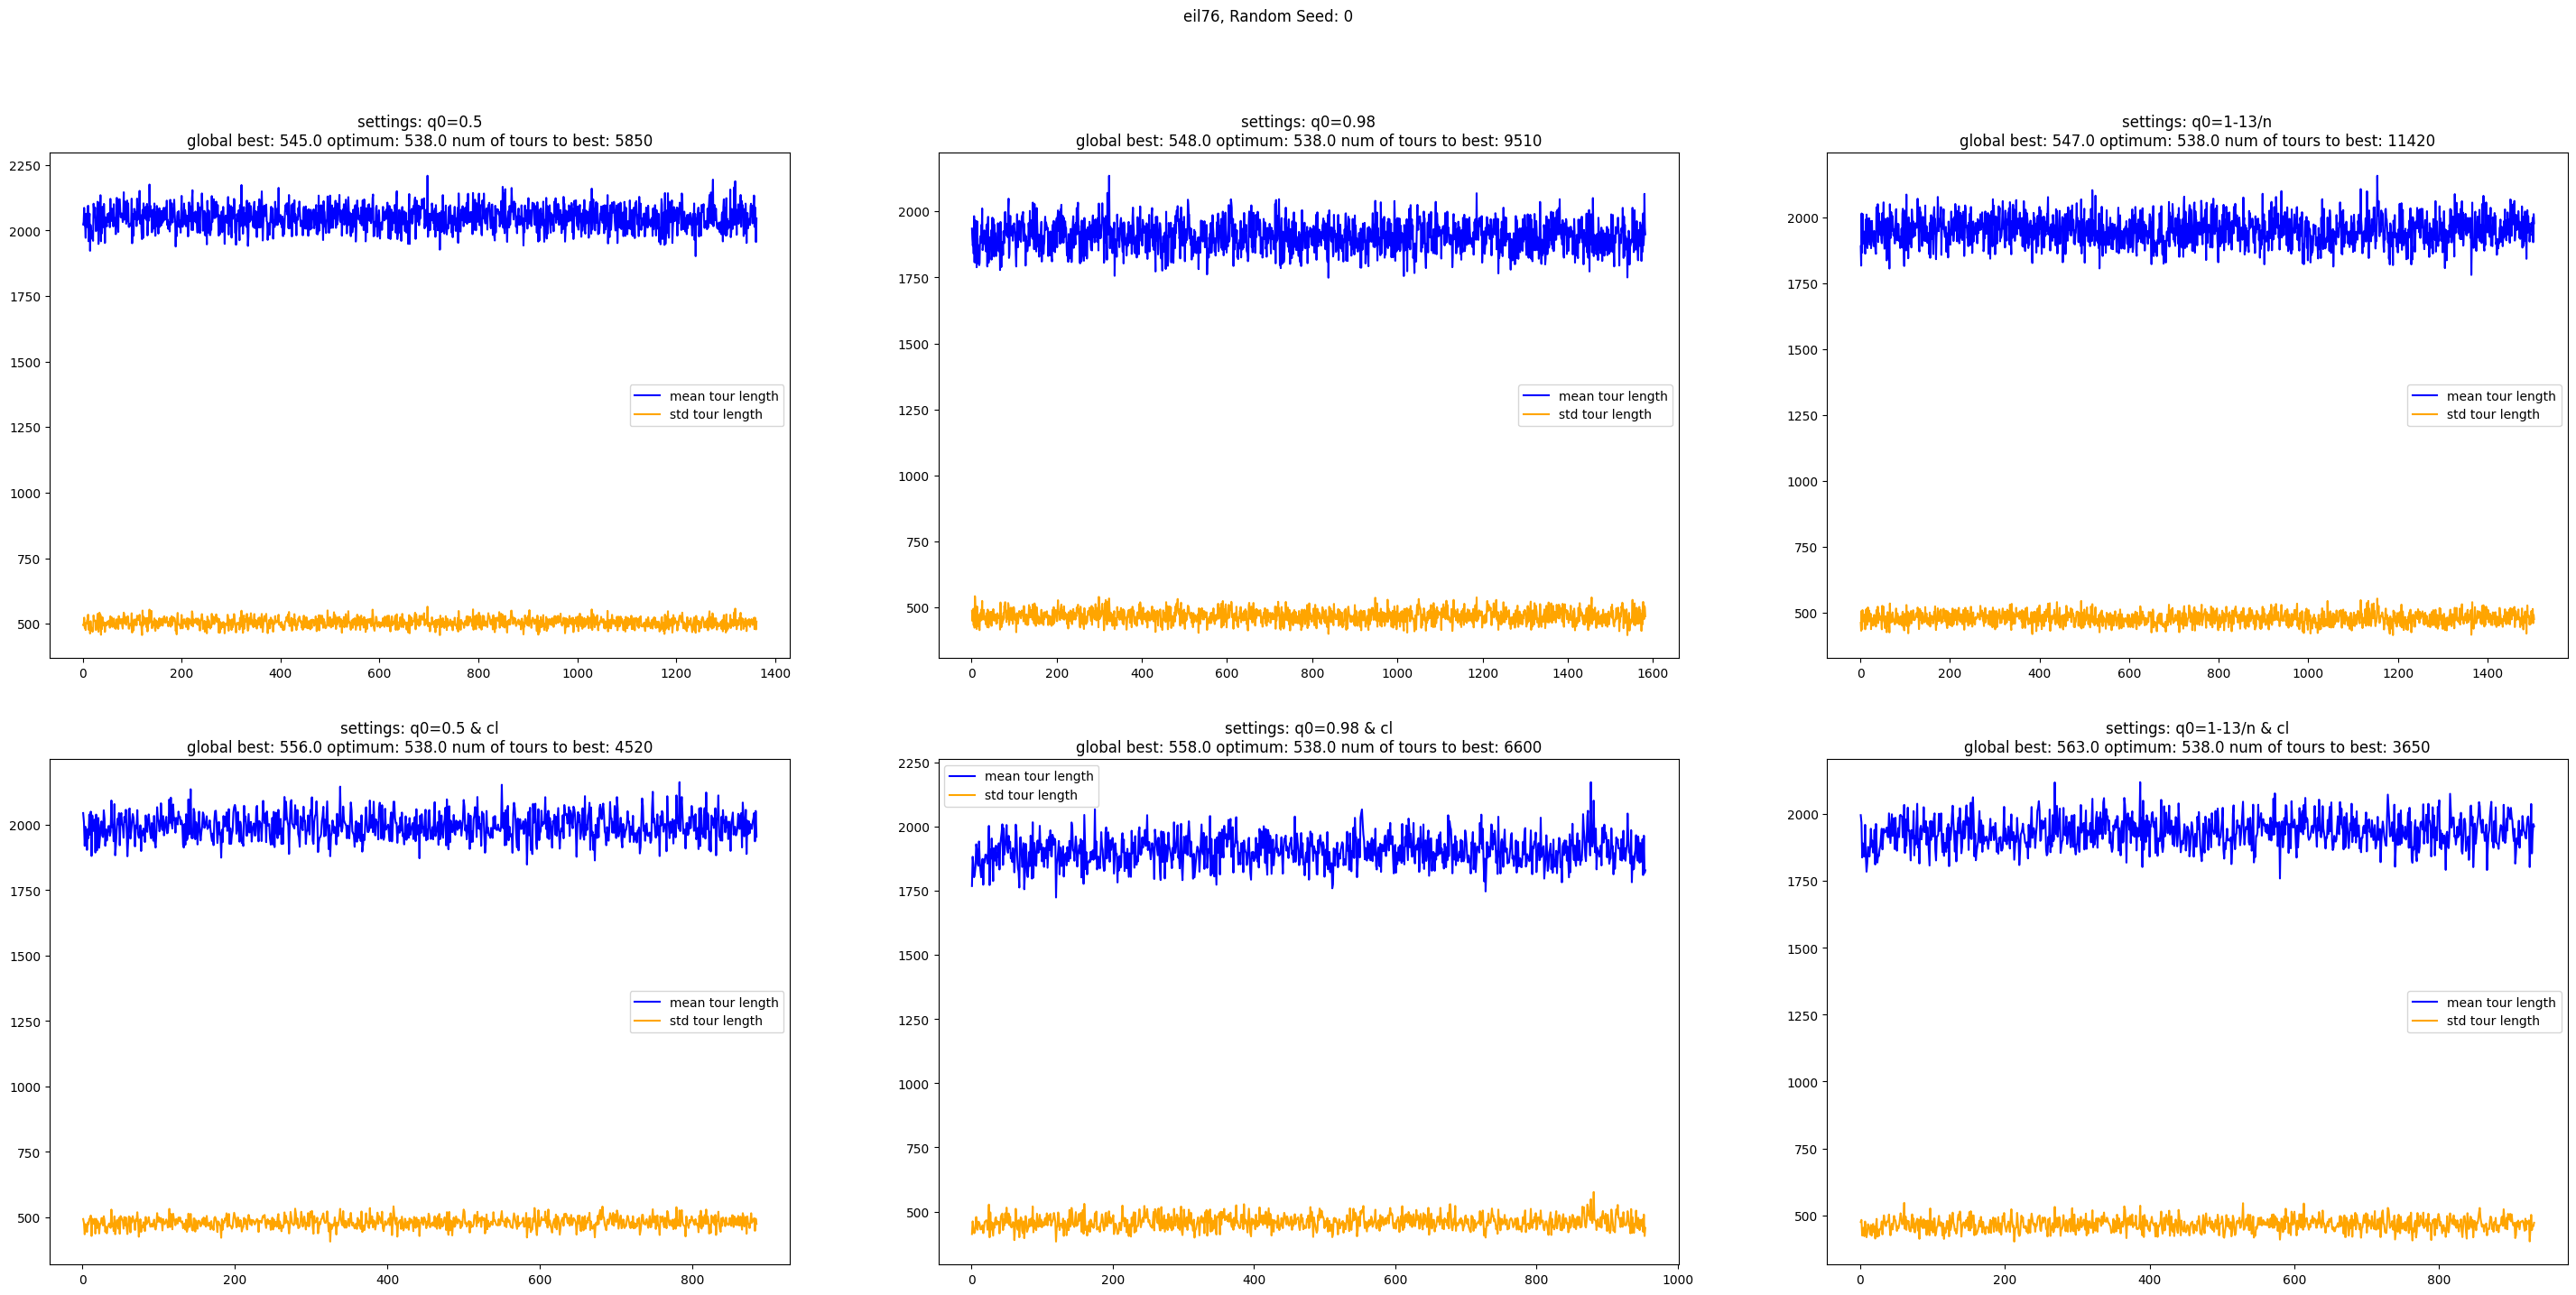

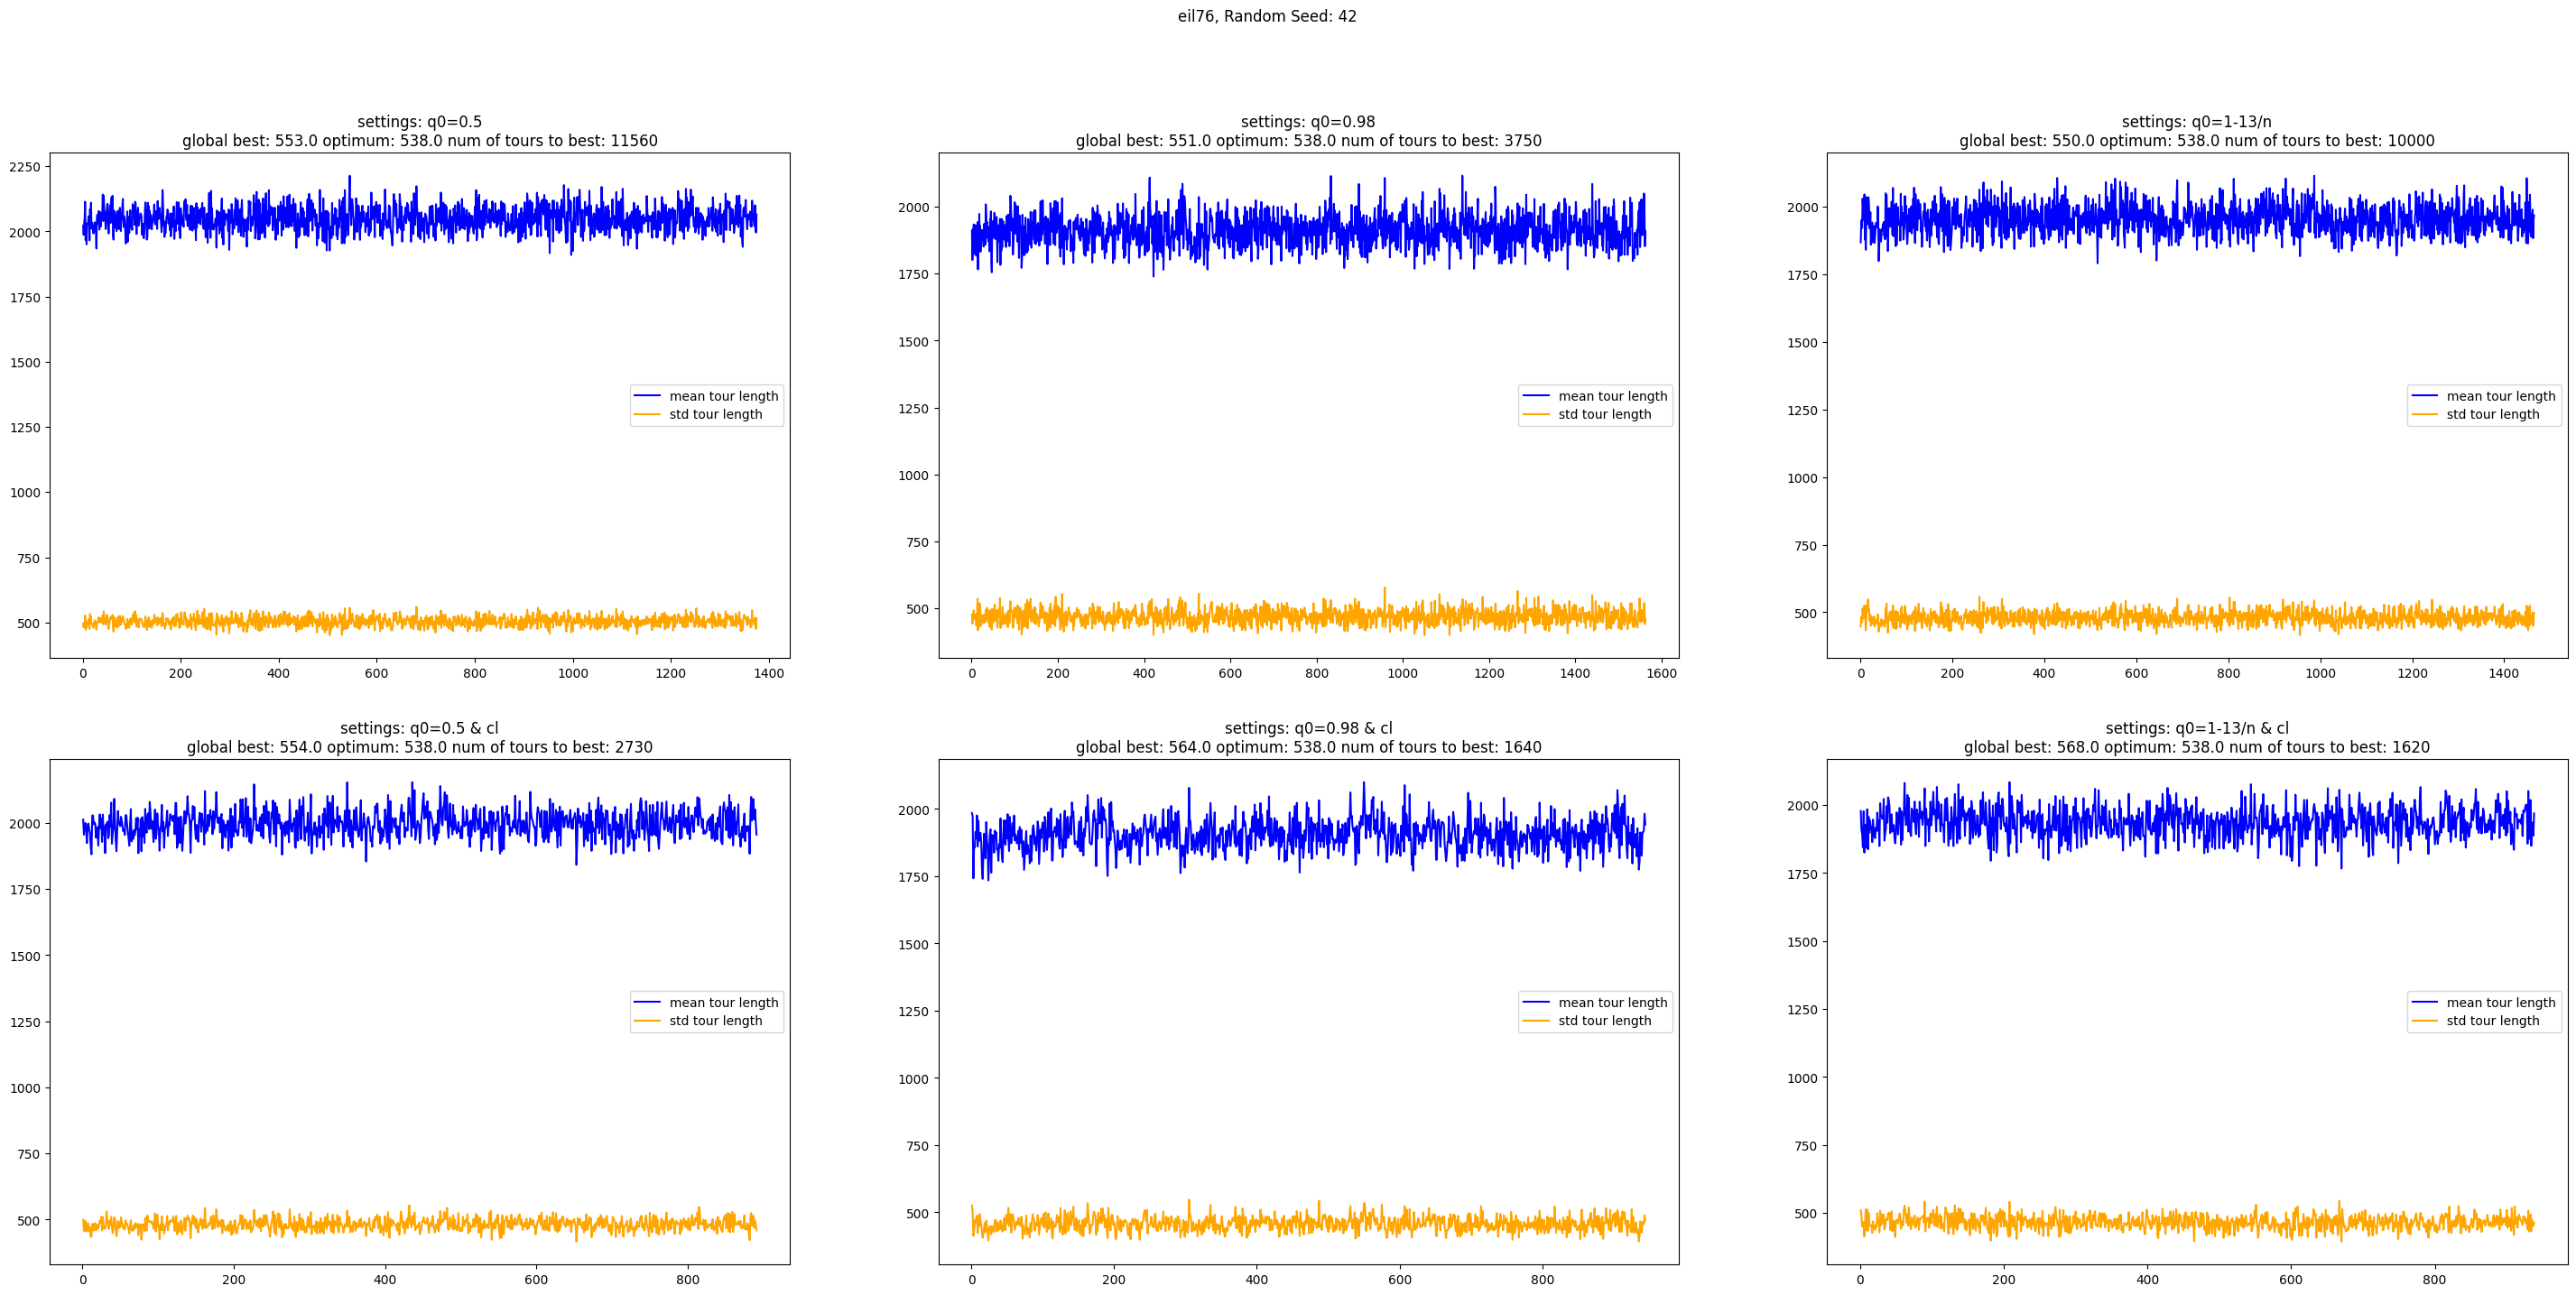

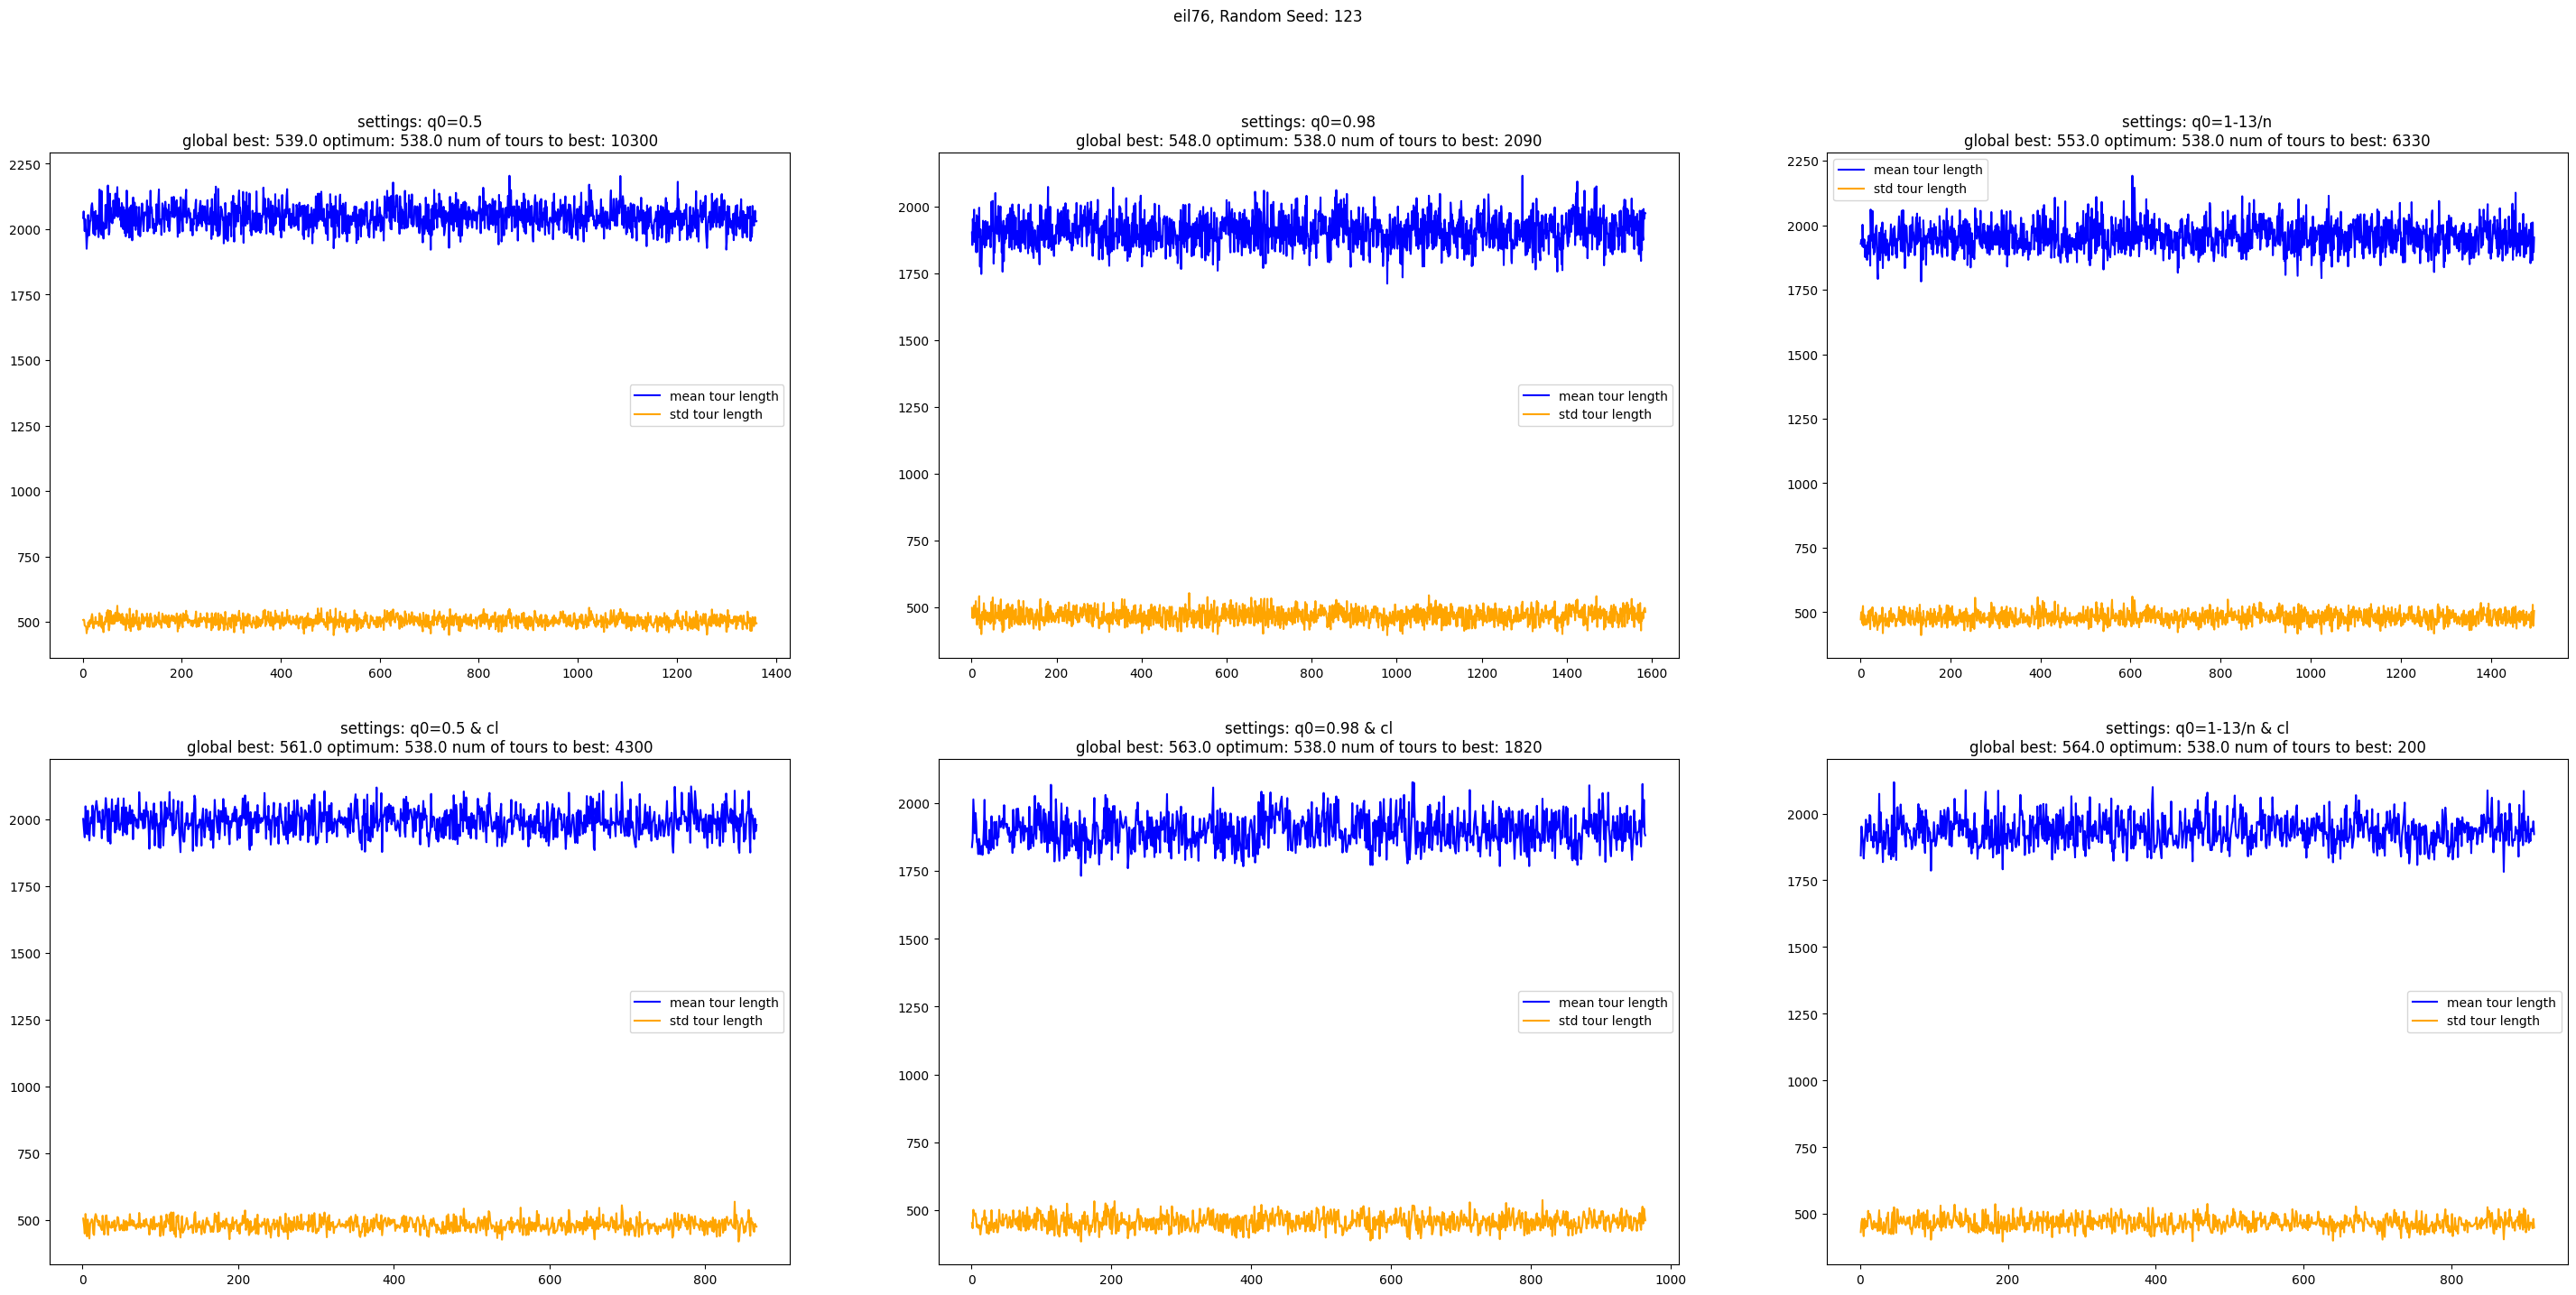

ch130


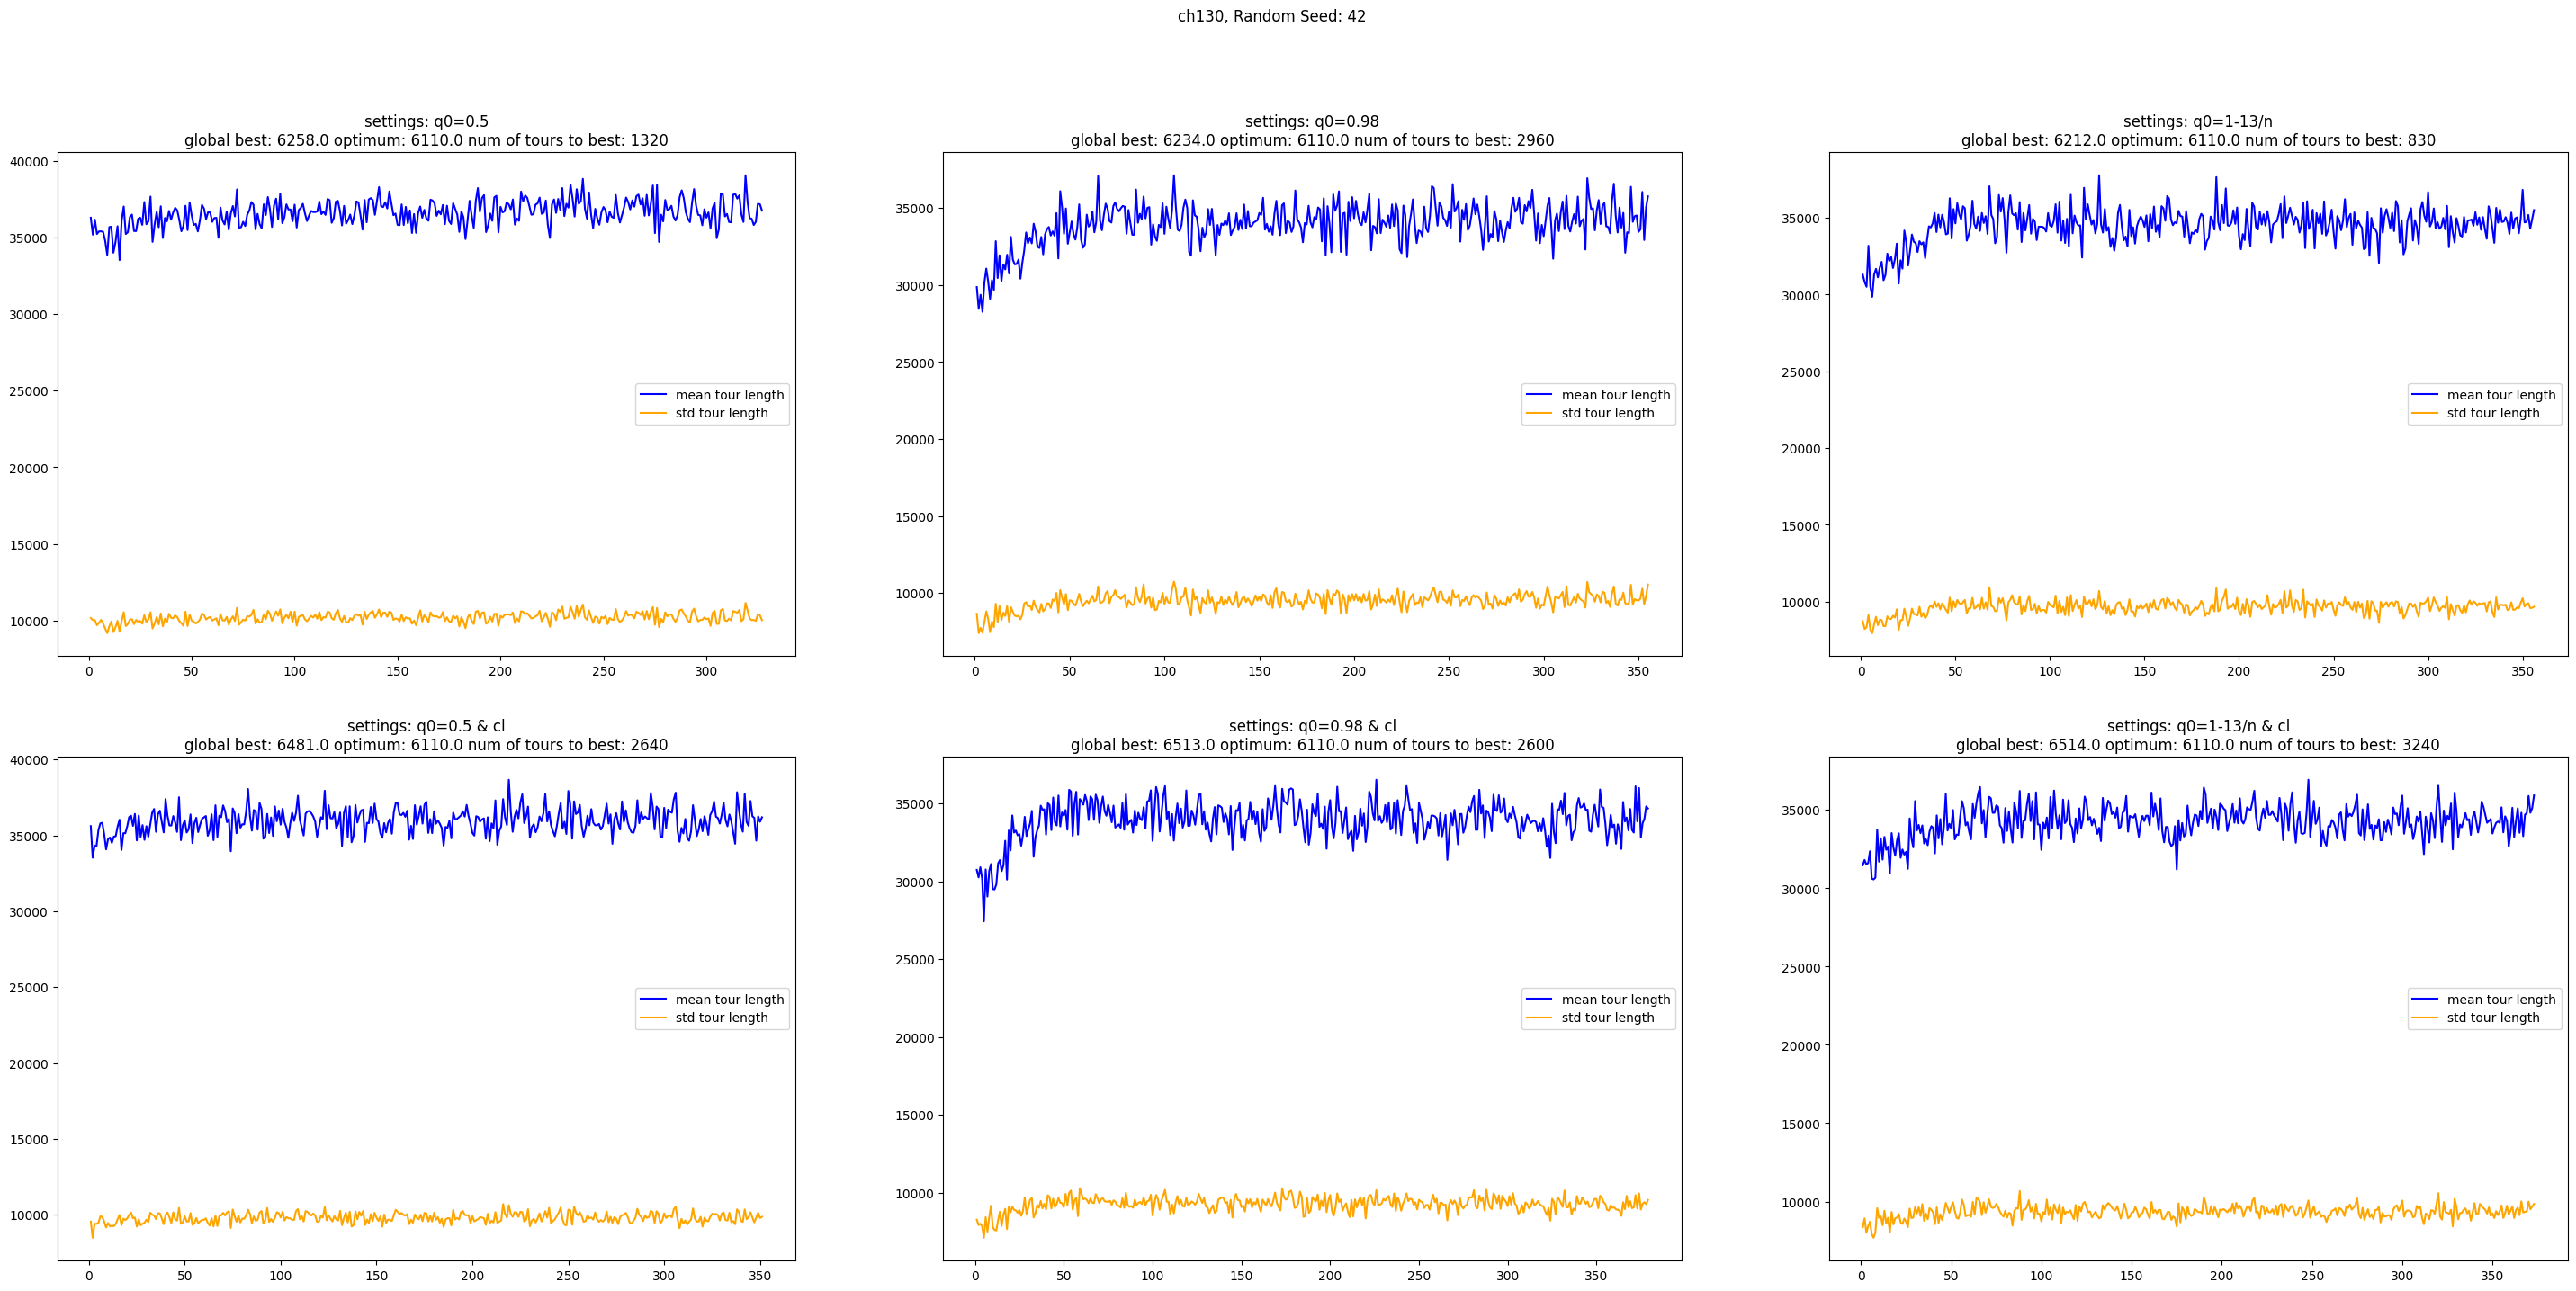

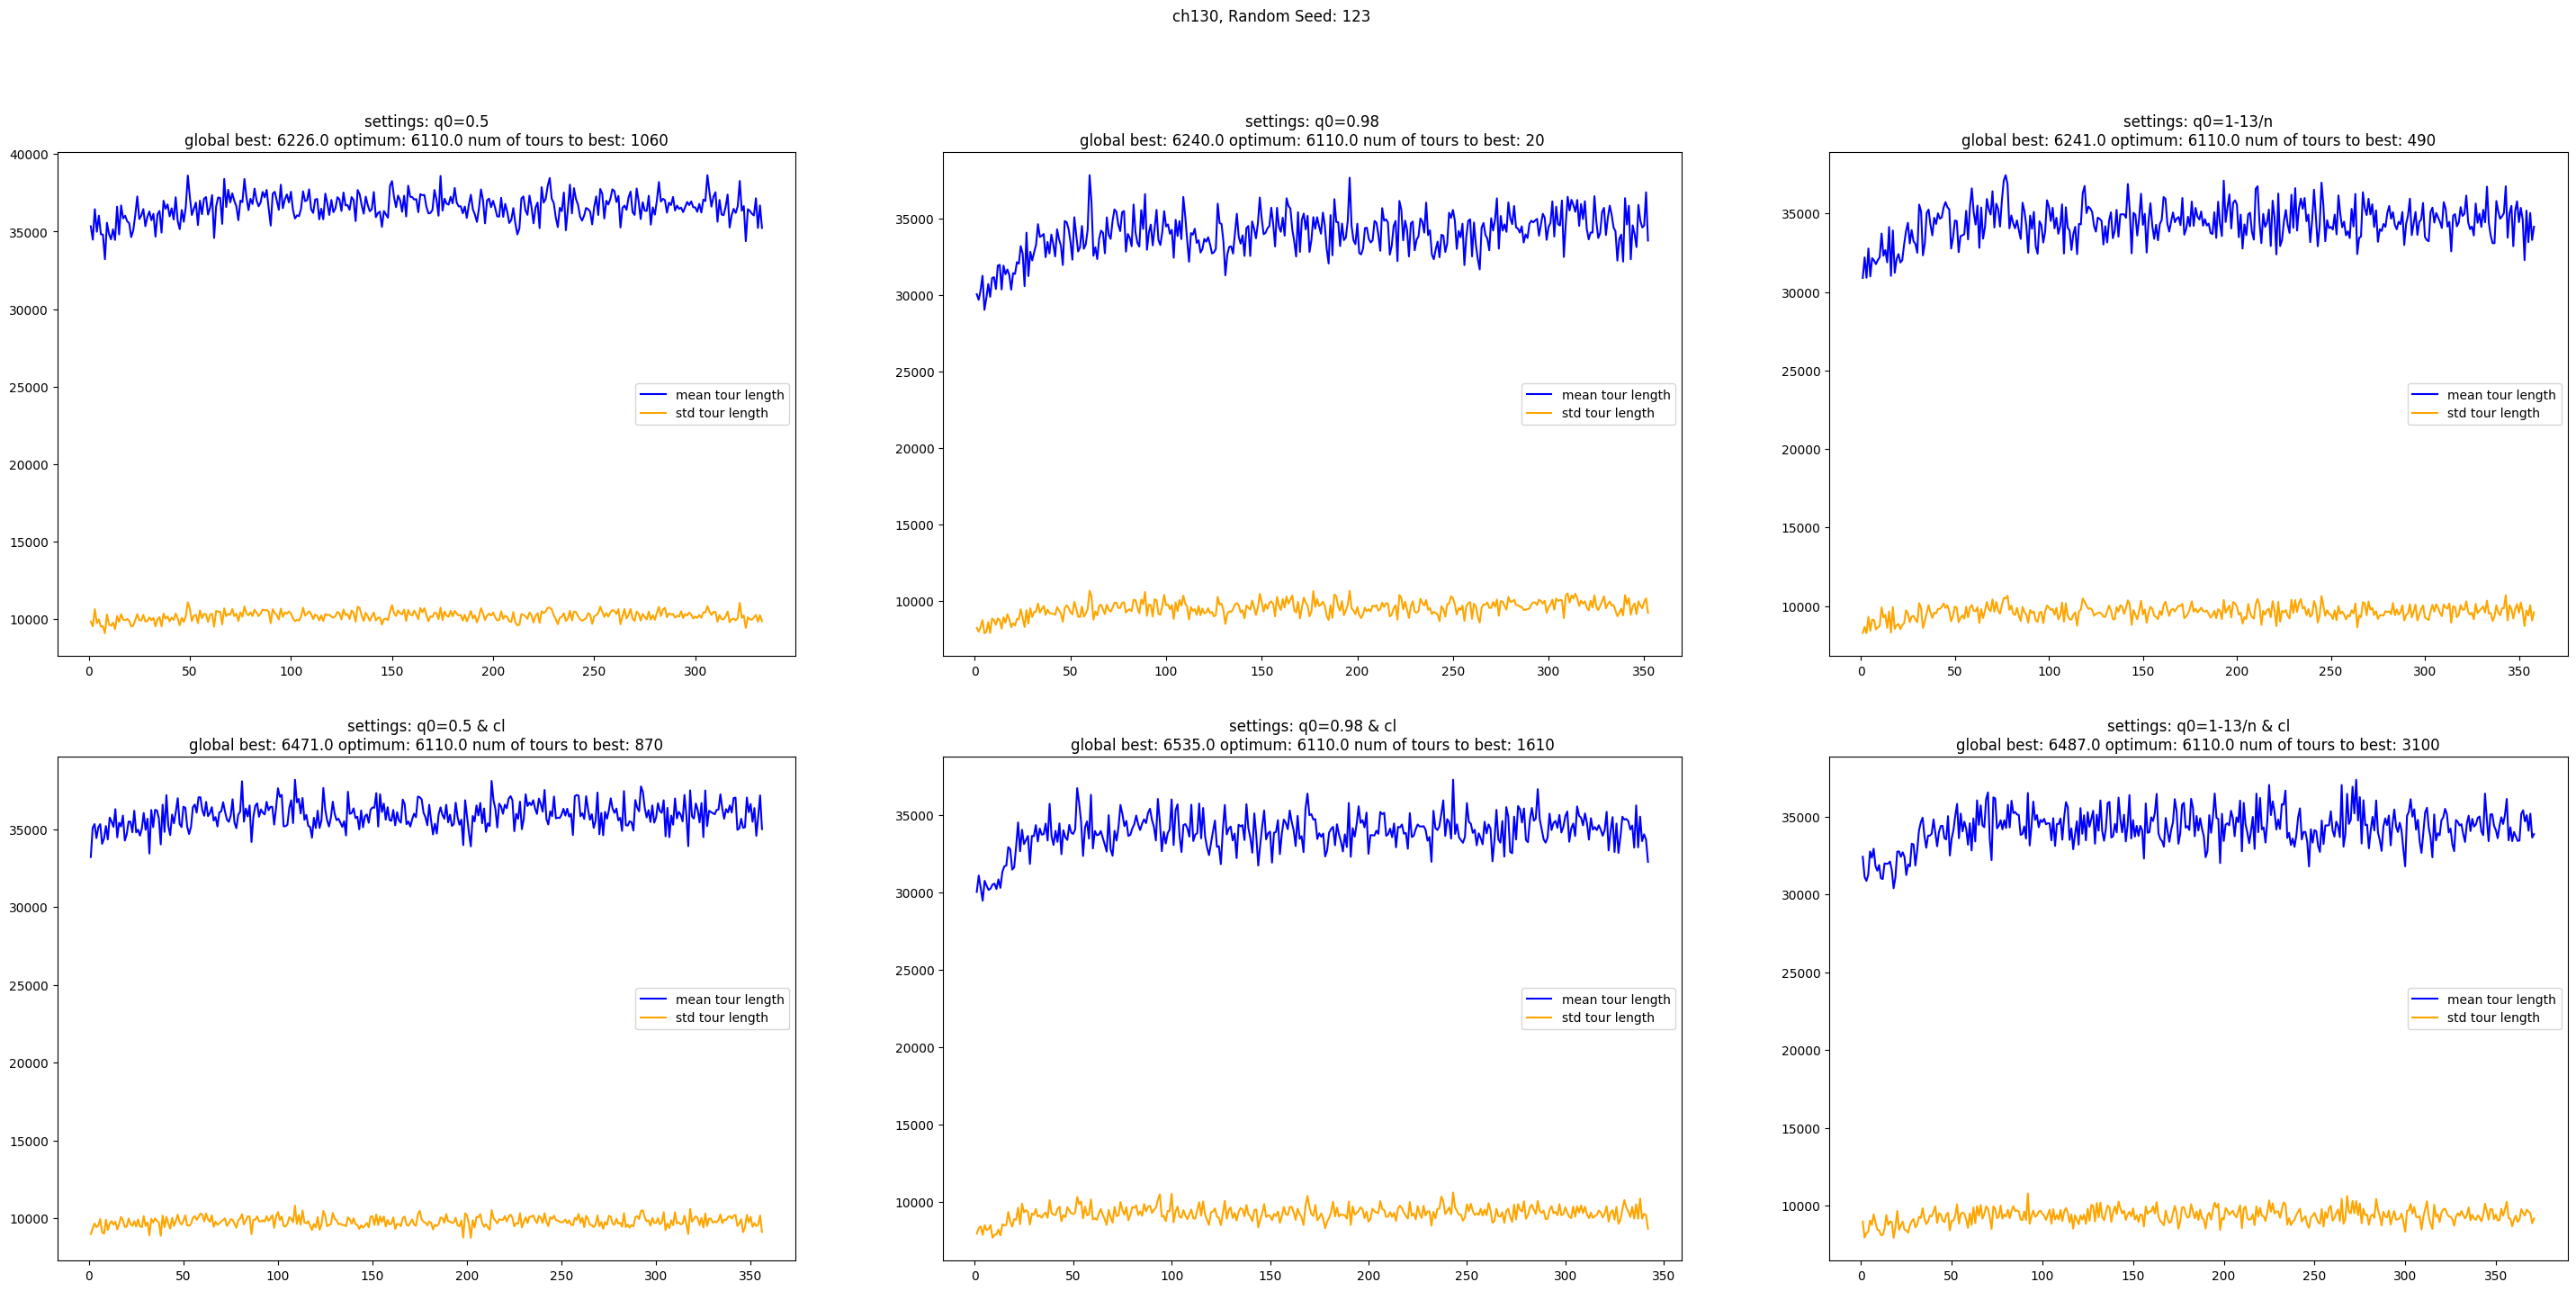

d198


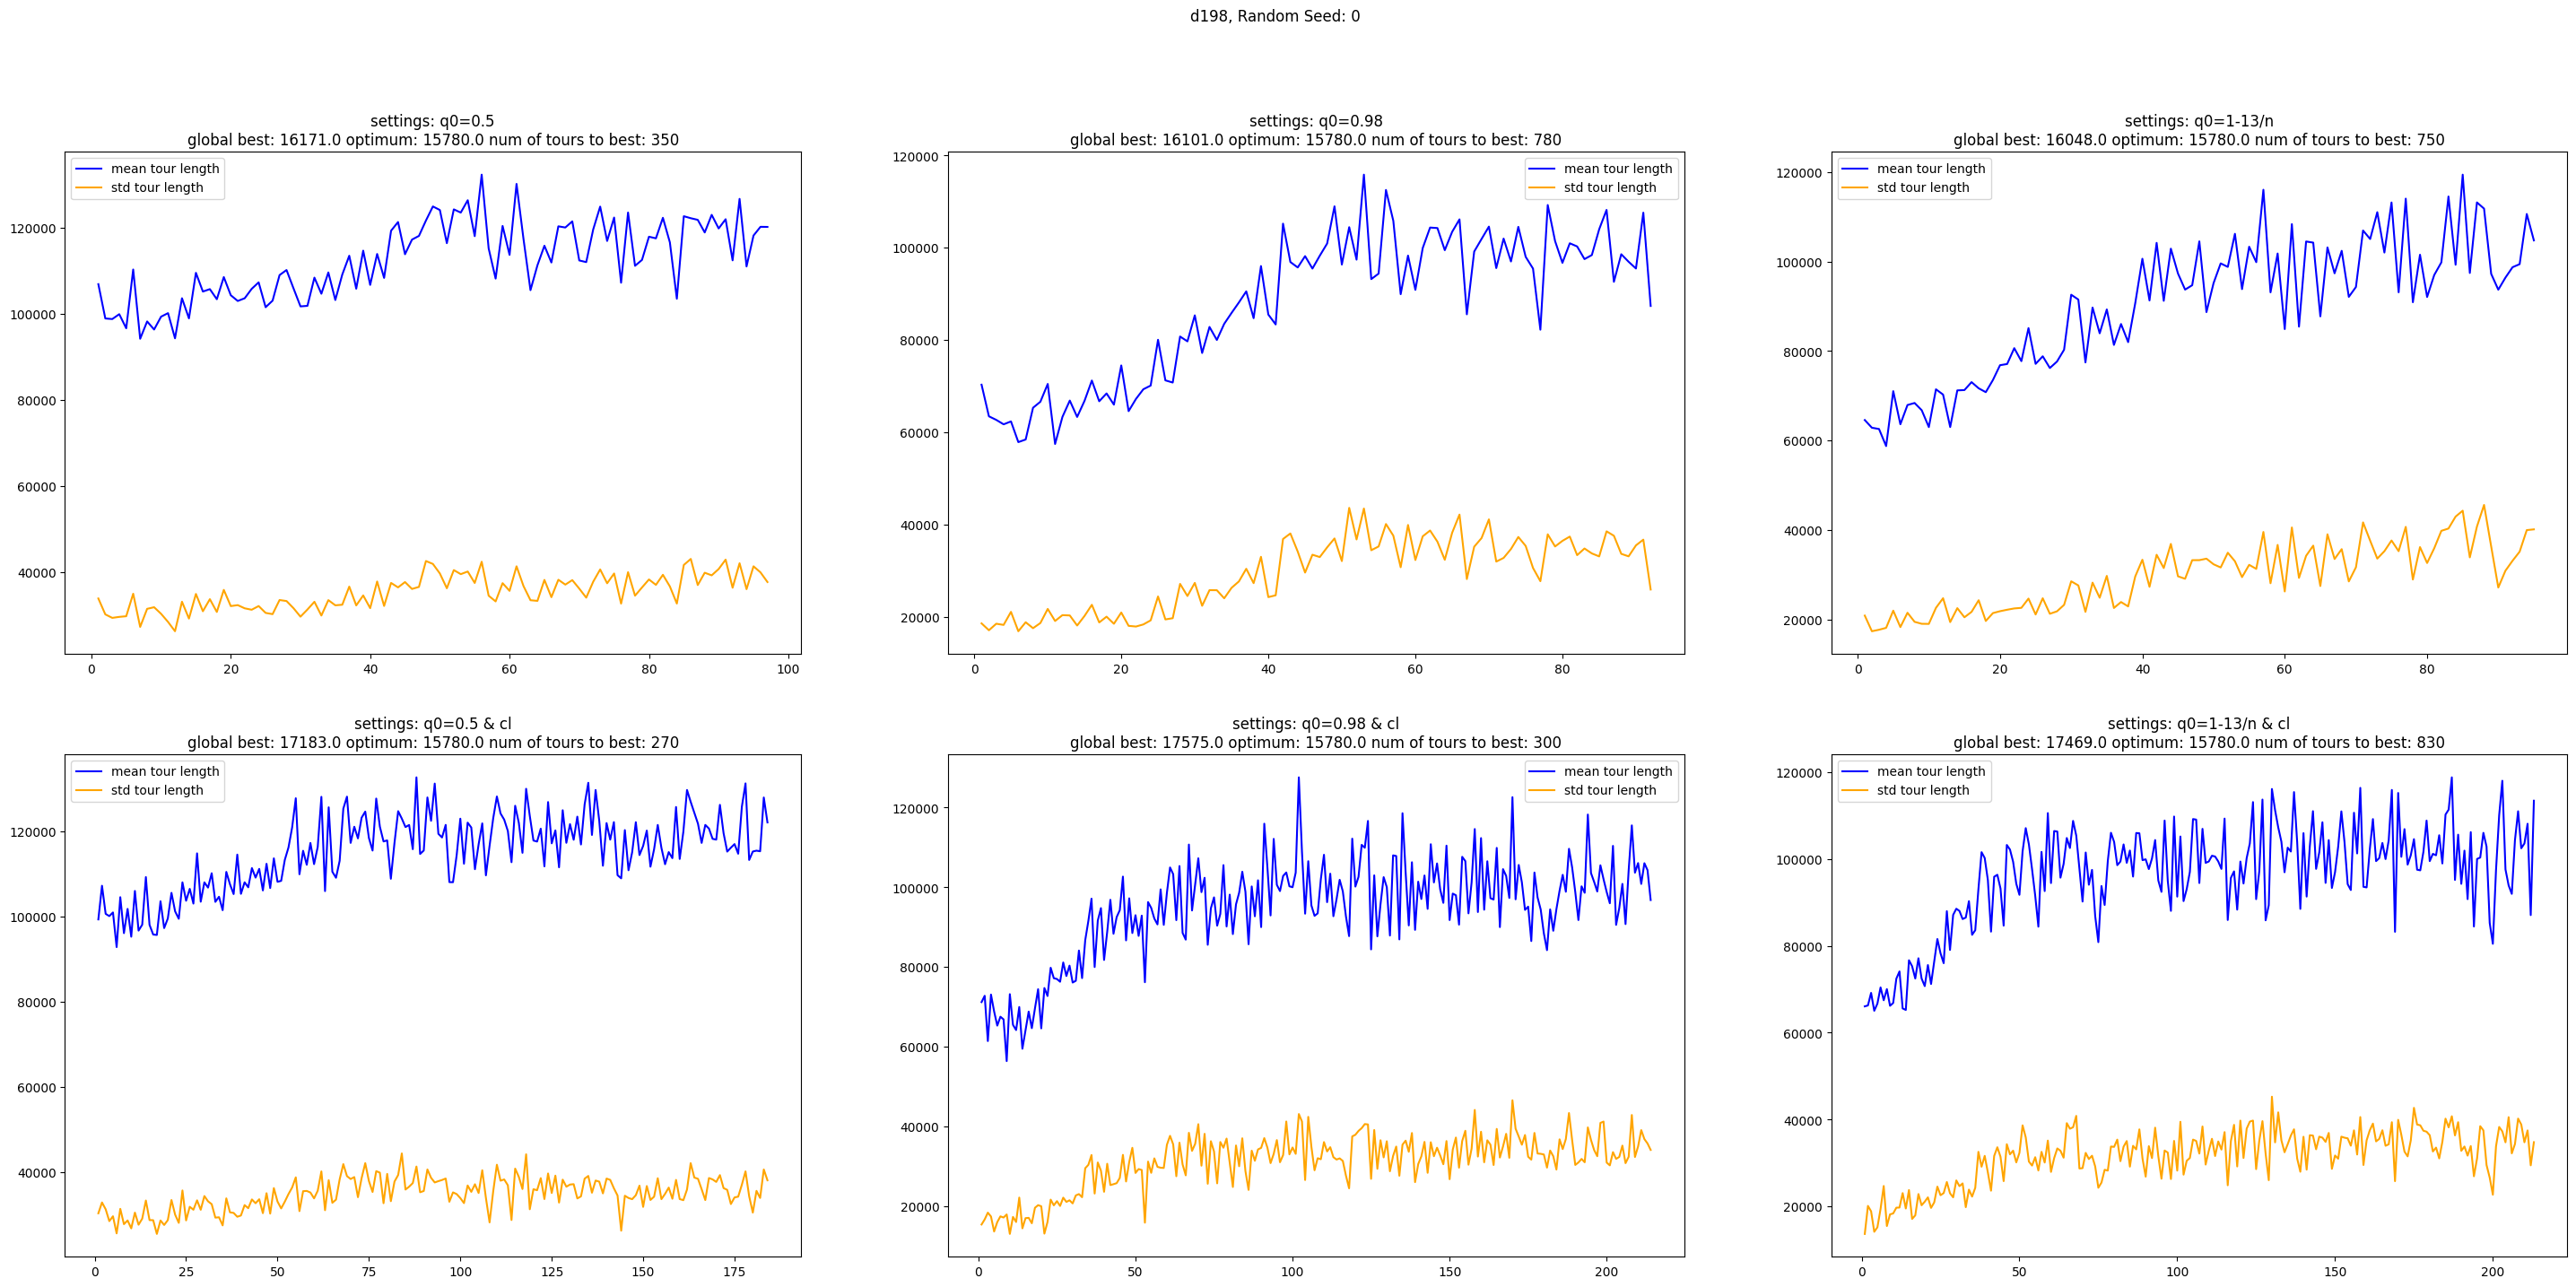

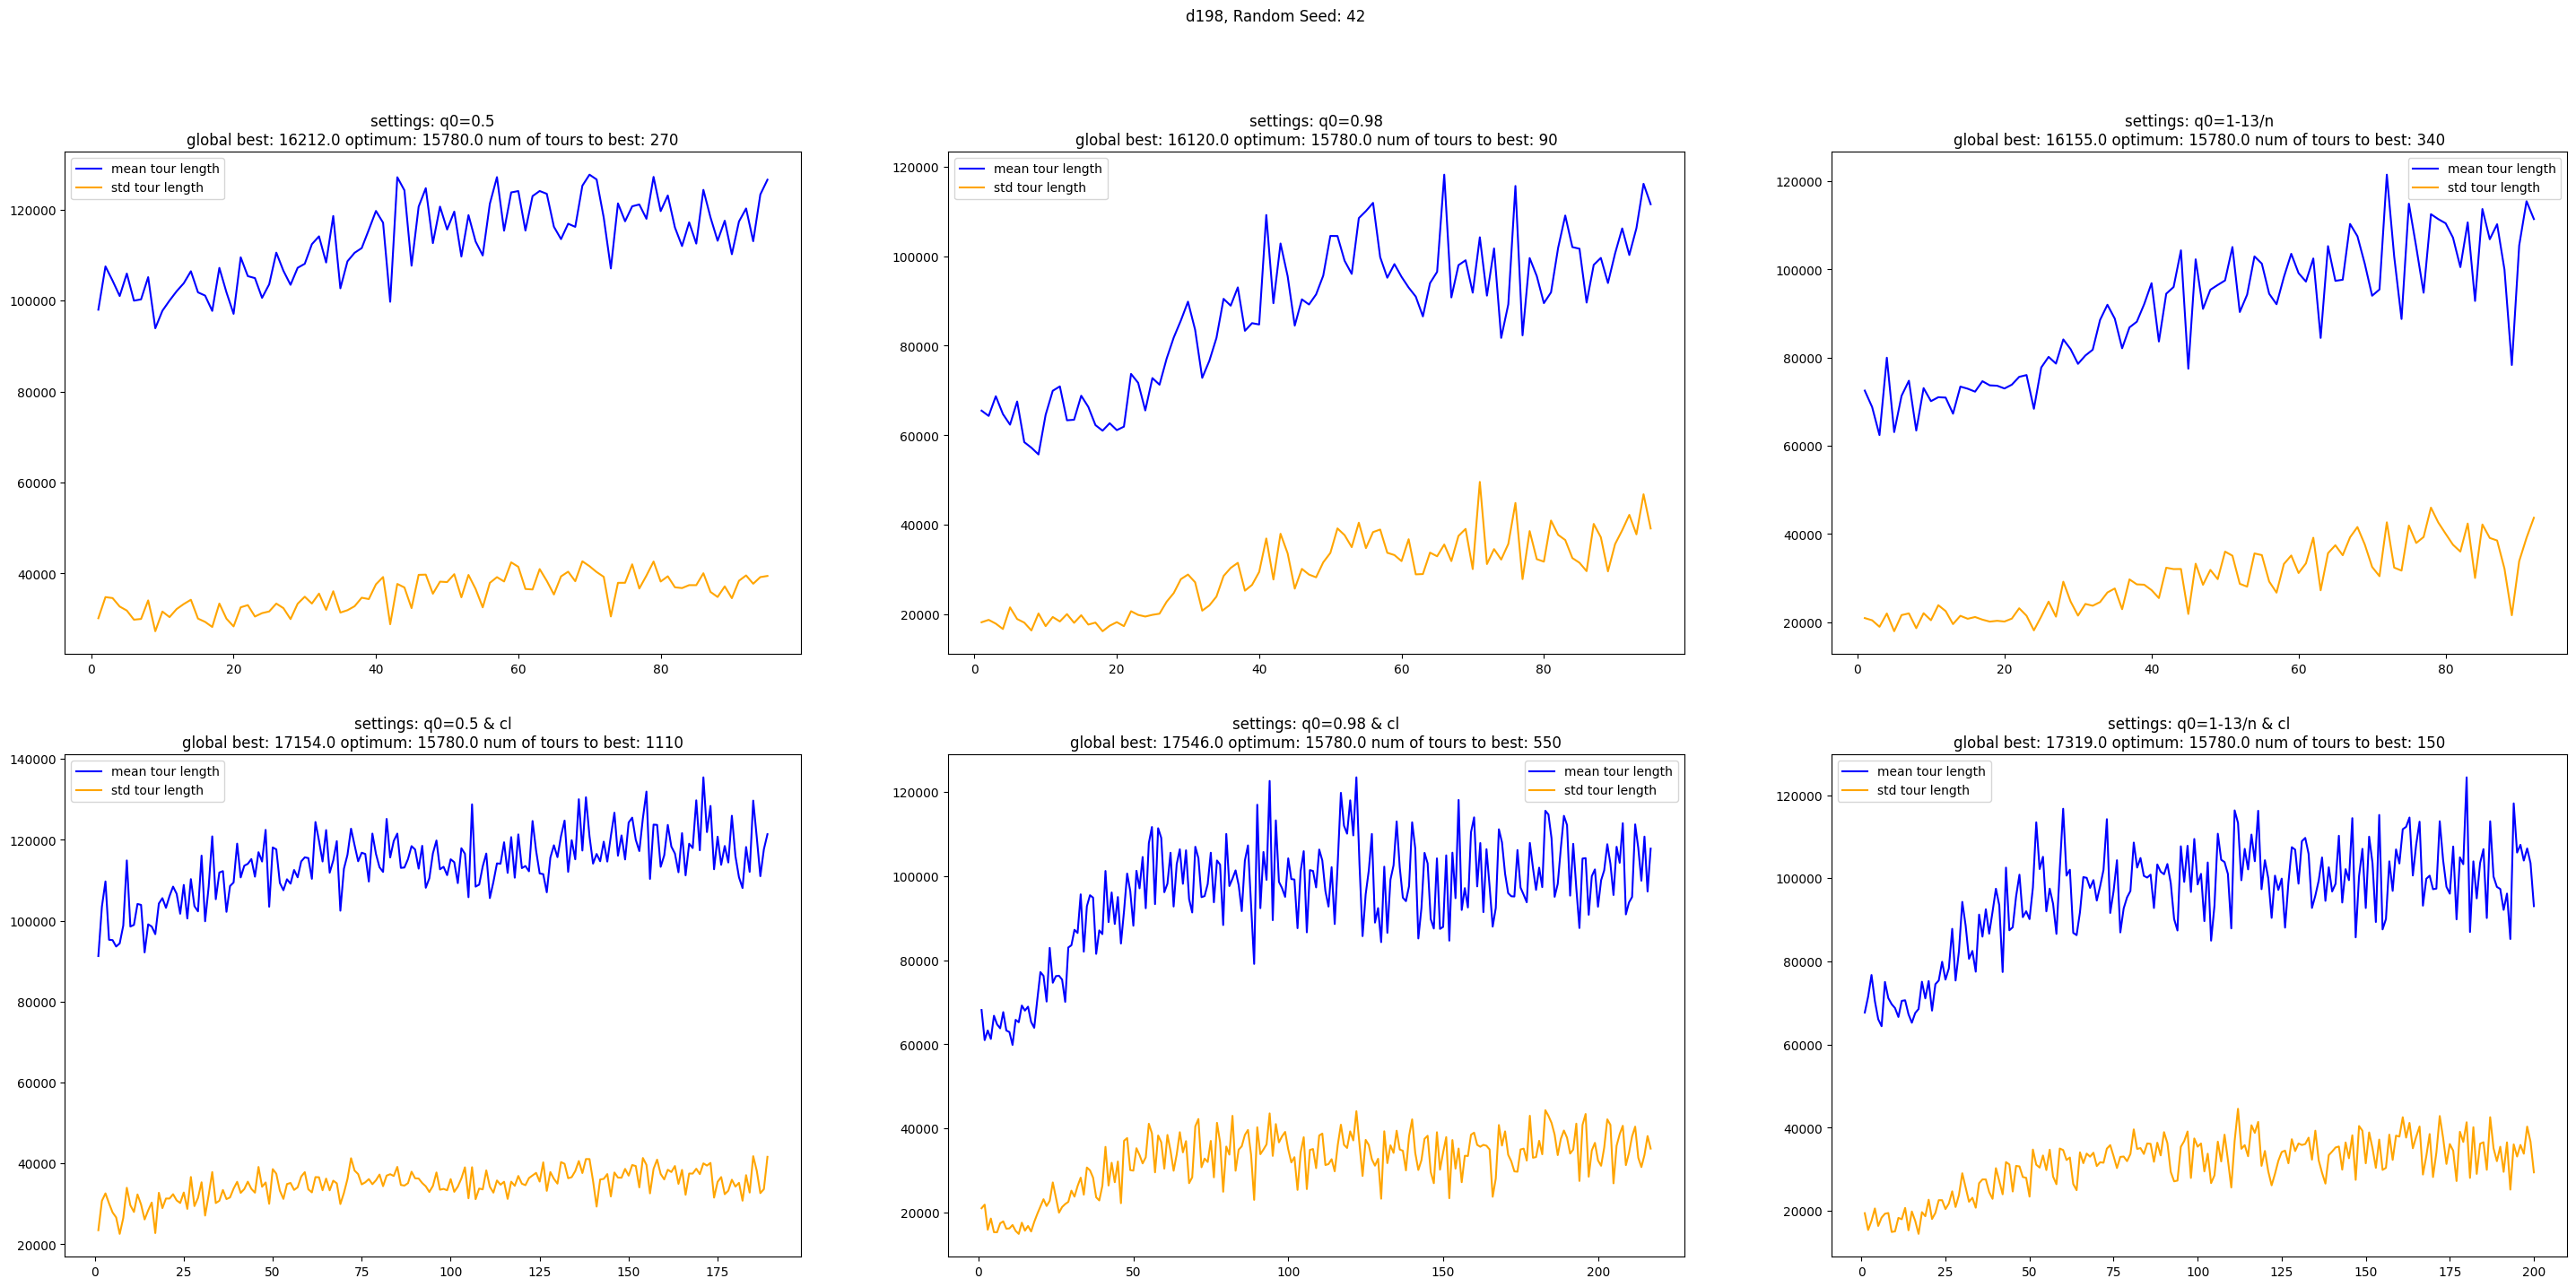

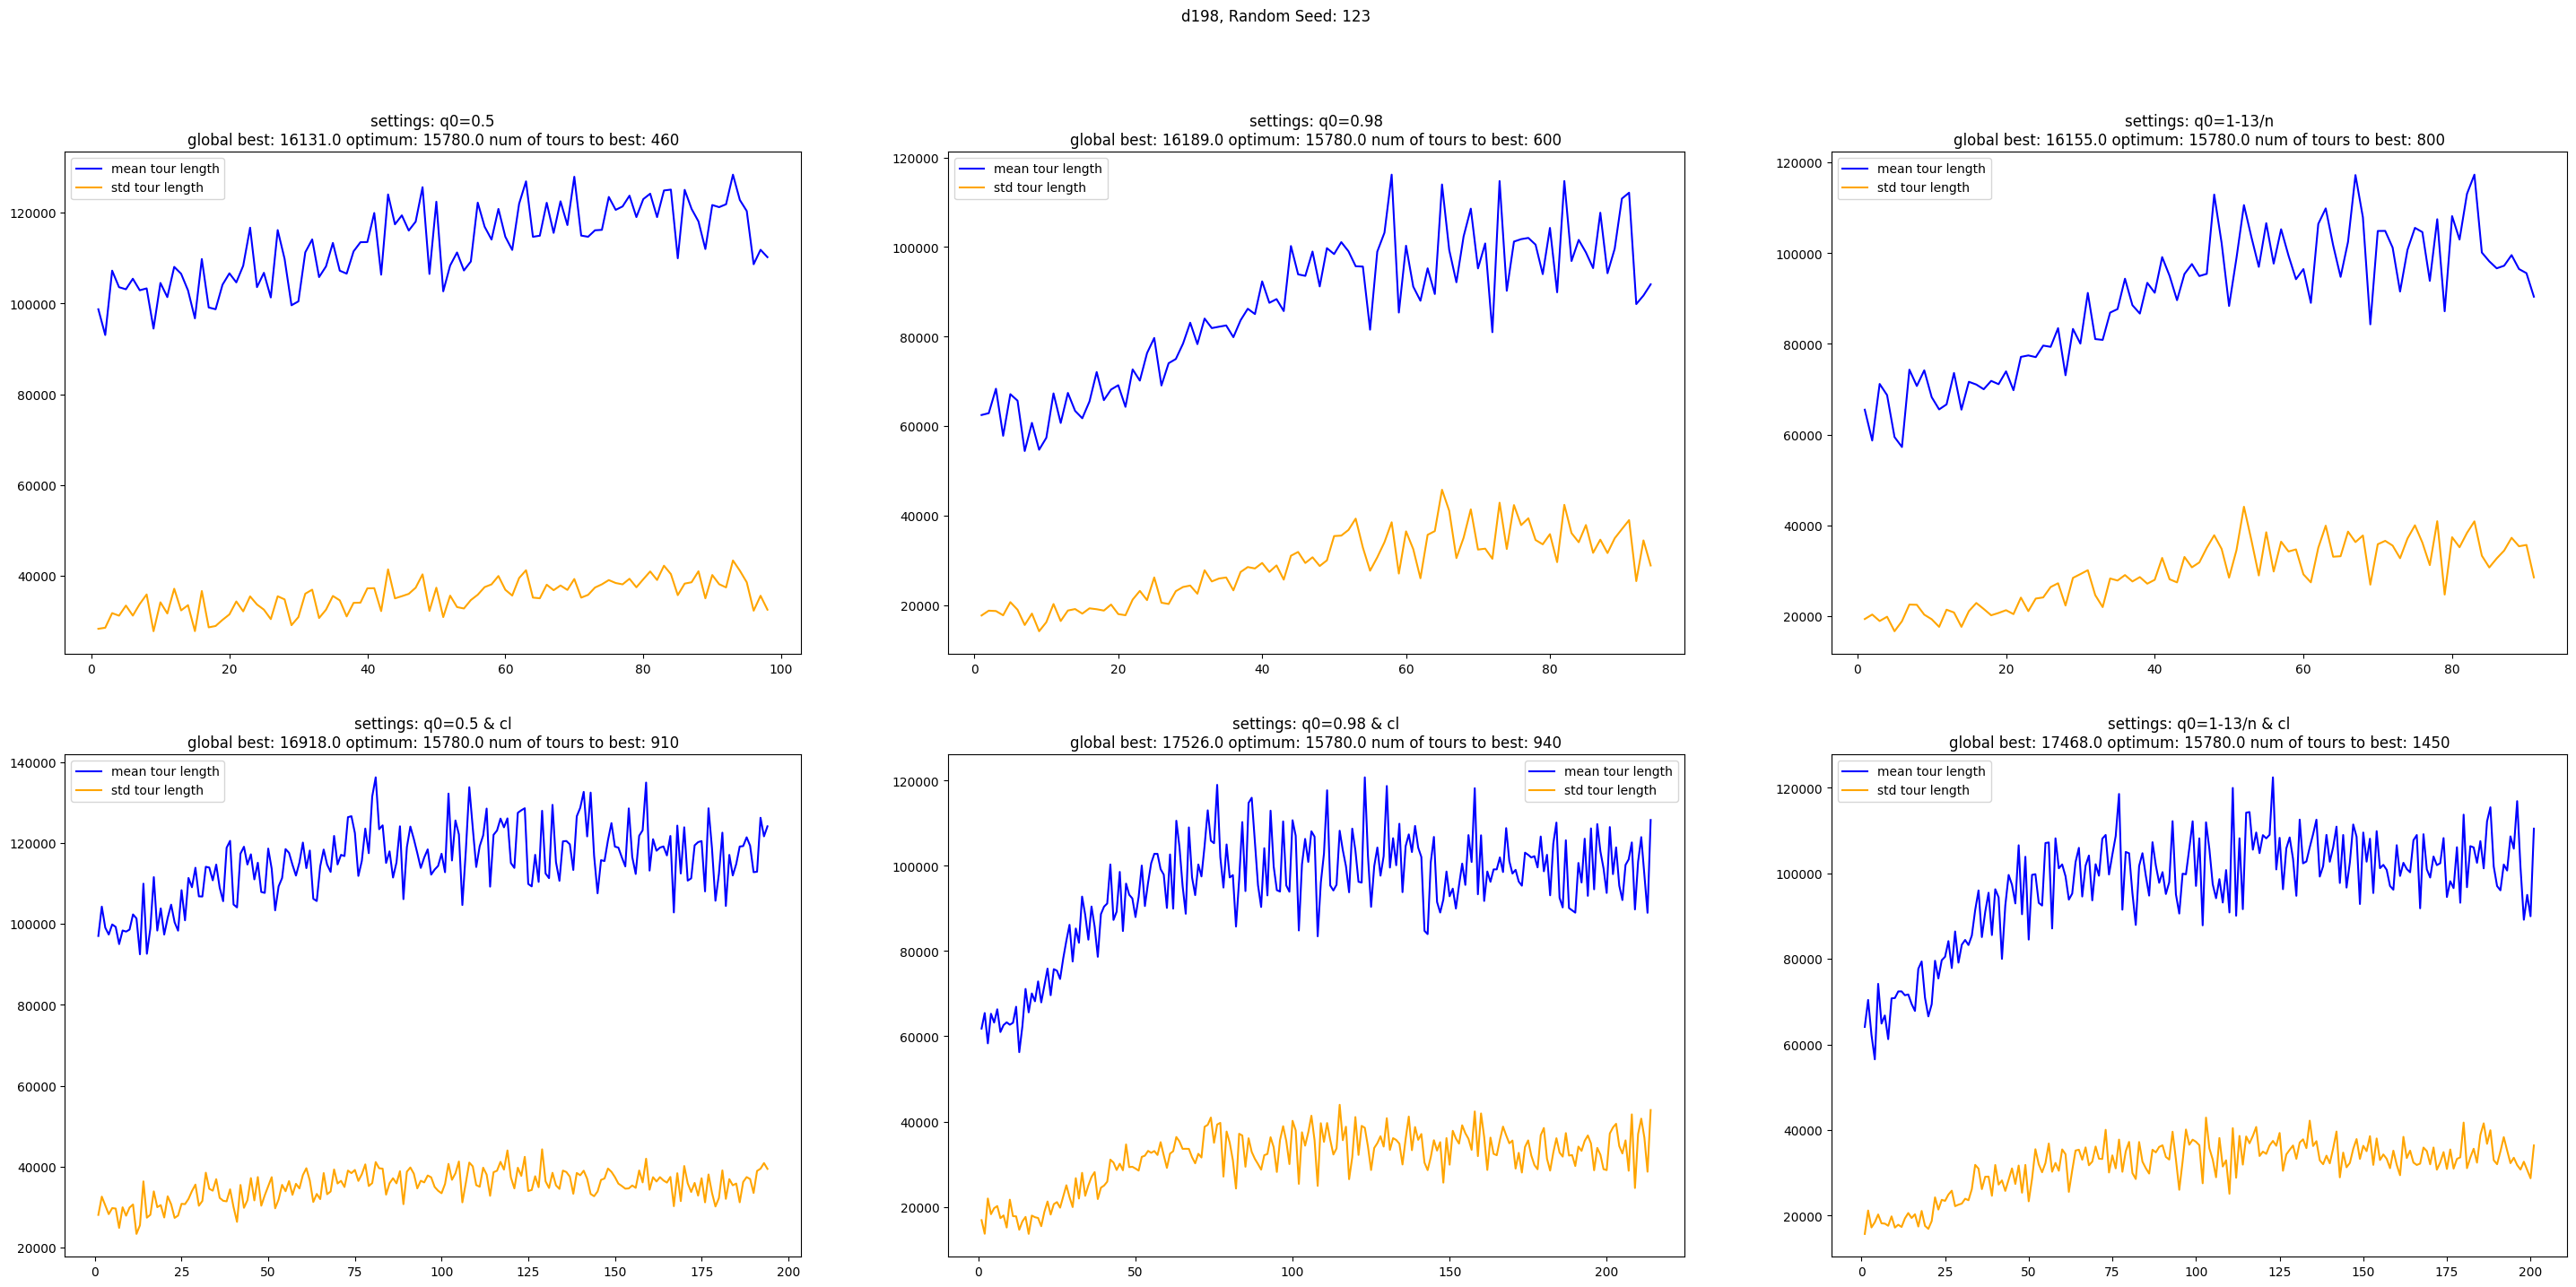

In [73]:
c_labels = ['Instance', 'q0', 'Candidate list', 'Seed', 'Best length', 'Tours to best', 'Optimum', 'Gap']
settings = ['q0=0.5', 'q0=0.5 & cl', 'q0=0.98', 'q0=0.98 & cl', 'q0=1-13/n', 'q0=1-13/n & cl']

data = []

for ic_name in instance_names:
  ic = TSP_Instance_Creator('standard',ic_name)
  print(ic.name)
  optimum_length = ic.best_sol
  # Plotting the results of the different settings for each seed.
  for seed in seeds:
    np.random.seed(seed)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36, 16))
    fig.suptitle(f'{ic.name}, Random Seed: {seed}')

    # Creating a new instance of the ACS class for each combination of settings, running the
    # algorithm and plotting the results.
    for q in range_q0:
      q0 = q0_list[q]
      for c_bool in candidate:
        acs = ACS(instance=ic, two_opt=True, q0=q0, candidate_bool = c_bool, runtime = 180)
        acs.solve()

        # Compute statistics

        best_length = acs.global_best
        tours_to_best = acs.tours_to_best
        gap = np.round(((best_length-optimum_length) / optimum_length)*100,3)
        best_iteration = acs.best_iteration
        num_iterations = acs.current_iteration

        avg_tour_length = acs.mean_length
        std_tour_length = acs.sd_length

        # Plot
        index = 2*q + int(c_bool)
        setting = settings[index]
        x = np.arange(num_iterations) + 1
        ax = axes[int(c_bool)][q]
        ax.plot(x,avg_tour_length,'blue',x,std_tour_length,'orange')
        title = title = f'settings: {setting}\nglobal best: {best_length} optimum: {optimum_length} num of tours to best: {tours_to_best}'
        ax.set_title(title)
        ax.legend(['mean tour length','std tour length'])

        # Populate dataframe
        data.append([ic.name, q0, c_bool, seed, best_length, tours_to_best, optimum_length, gap])

  plt.show()

df = pd.DataFrame(data, columns=c_labels)

In [74]:
df

Instance        q0  Candidate list  Seed Best length  Tours to best  \
0     eil76       0.5           False     0       545.0           5850   
1     eil76       0.5            True     0       556.0           4520   
2     eil76      0.98           False     0       548.0           9510   
3     eil76      0.98            True     0       558.0           6600   
4     eil76  adaptive           False     0       547.0          11420   
5     eil76  adaptive            True     0       563.0           3650   
6     eil76       0.5           False    42       553.0          11560   
7     eil76       0.5            True    42       554.0           2730   
8     eil76      0.98           False    42       551.0           3750   
9     eil76      0.98            True    42       564.0           1640   
10    eil76  adaptive           False    42       550.0          10000   
11    eil76  adaptive            True    42       568.0           1620   
12    eil76       0.5           False   123       539.0          10300   
13    eil76       0.5            True   123       561.0           4300   
14    eil76      0.98           False   123       548.0           2090   
15    eil76      0.98            True   123       563.0           1820   
16    eil76  adaptive           False   123       553.0           6330   
17    eil76  adaptive            True   123       564.0            200   
18    ch130       0.5           False     0      6245.0           2510   
19    ch130       0.5            True     0      6538.0           2490   
20    ch130      0.98           False     0      6228.0           1730   
21    ch130      0.98            True     0      6496.0           2580   
22    ch130  adaptive           False     0      6287.0           3140   
23    ch130  adaptive            True     0      6369.0           2230   
24    ch130       0.5           False    42      6258.0           1320   
25    ch130       0.5            True    42      6481.0           2640   
26    ch130      0.98           False    42      6234.0           2960   
27    ch130      0.98            True    42      6513.0           2600   
28    ch130  adaptive           False    42      6212.0            830   
29    ch130  adaptive            True    42      6514.0           3240   
30    ch130       0.5           False   123      6226.0           1060   
31    ch130       0.5            True   123      6471.0            870   
32    ch130      0.98           False   123      6240.0             20   
33    ch130      0.98            True   123      6535.0           1610   
34    ch130  adaptive           False   123      6241.0            490   
35    ch130  adaptive            True   123      6487.0           3100   
36     d198       0.5           False     0     16171.0            350   
37     d198       0.5            True     0     17183.0            270   
38     d198      0.98           False     0     16101.0            780   
39     d198      0.98            True     0     17575.0            300   
40     d198  adaptive           False     0     16048.0            750   
41     d198  adaptive            True     0     17469.0            830   
42     d198       0.5           False    42     16212.0            270   
43     d198       0.5            True    42     17154.0           1110   
44     d198      0.98           False    42     16120.0             90   
45     d198      0.98            True    42     17546.0            550   
46     d198  adaptive           False    42     16155.0            340   
47     d198  adaptive            True    42     17319.0            150   
48     d198       0.5           False   123     16131.0            460   
49     d198       0.5            True   123     16918.0            910   
50     d198      0.98           False   123     16189.0            600   
51     d198      0.98            True   123     17526.0            940   
52     d198  adaptive           False   123     16155.0            800   
53     

**Now I take the results avaraged on seeds**

In [75]:
duplicate_rows = df[df.duplicated(subset=['Instance', 'q0', 'Candidate list', 'Optimum'], keep=False)]
aggregation = {'Best length': 'mean', 'Tours to best': 'mean', 'Gap': 'mean'}
small_df = duplicate_rows.groupby(['Instance', 'q0', 'Candidate list', 'Optimum'], as_index=False).agg(aggregation)
small_df = small_df.round({'Best length': 3, 'Tours to best': 3, 'Gap': 3})
small_df_sorted = small_df.sort_values(by='Best length', ascending=True)
small_df_sorted

Instance        q0  Candidate list  Optimum  Best length  Tours to best  \
12    eil76       0.5           False    538.0      545.667       9236.667   
14    eil76      0.98           False    538.0      549.000       5116.667   
16    eil76  adaptive           False    538.0      550.000       9250.000   
13    eil76       0.5            True    538.0      557.000       3850.000   
15    eil76      0.98            True    538.0      561.667       3353.333   
17    eil76  adaptive            True    538.0      565.000       1823.333   
2     ch130      0.98           False   6110.0     6234.000       1570.000   
0     ch130       0.5           False   6110.0     6243.000       1630.000   
4     ch130  adaptive           False   6110.0     6246.667       1486.667   
5     ch130  adaptive            True   6110.0     6456.667       2856.667   
1     ch130       0.5            True   6110.0     6496.667       2000.000   
3     ch130      0.98            True   6110.0     6514.667       2263.333   
10     d198  adaptive           False  15780.0    16119.333        630.000   
8      d198      0.98           False  15780.0    16136.667        490.000   
6      d198       0.5           False  15780.0    16171.333        360.000   
7      d198       0.5            True  15780.0    17085.000        763.333   
11     d198  adaptive            True  15780.0    17418.667        810.000   
9      d198      0.98            True  15780.0    17549.000        596.667   

       Gap  
12   1.425  
14   2.045  
16   2.230  
13   3.532  
15   4.399  
17   5.019  
2    2.029  
0    2.177  
4    2.237  
5    5.674  
1    6.328  
3    6.623  
10   2.150  
8    2.260  
6    2.480  
7    8.270  
11  10.384  
9   11.210

# Report

In this section I will comment the results obtained.

I have created two dataframes: `df`, which contains all the 54 runs of the procedure in order of execution; and `small_df_sorted`, which is obtained from the original by avaraging over the seeds and sorting the instances in ascending order of the `Best lenght` variable.

*   It is immediately noticed that the procedure performs always better when the candidate list is not implemented. Therefore, my analysis will focus mainly on the experiments without the candidate list.

*   The **avarage** gaps are very promising when the candidate list is not implemented: they range between 1.425% and 2.48%. The lowest gap ever found is at row 12 of `df` and corresponds to: instance=eil76, q0=0.5,	candidate list=False, seed=123, best length= 539.0, number of tours genereted before the global best=10300, optimal solution=538.0.
On the other hand, when the candidate list is implemented they are much higher, with a peak of 11.21% (on avarage).

*   In smaller instances, more tours are generated before fining the shortest one with respect to larger instances. This was expected because we fix the running time and consequently the procedure does more iterations in smaller instances.

*   No value for q0 seems to be preferable to the other ones, nor in terms of gap nor in terms of number of iterations before finding the shortest path.

*   The plots about the mean tour lengths and their standard deviations look similar: they have an initial increasing trend for the first 50-100 iterations, then they seem to fluctuate with no precise trend.

